# IE 6400 Foundations for Data Analytics Engineering: Project 1
<b>Topic:</b> Cleaning and Analyzing Crime Data <br>
</b> Bharath Raj Pragada

## Installing & loading packages

In [211]:
!pip install prophet

In [212]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from prophet import Prophet
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

## Data Inspection:

### Importing the data:

In [213]:
crime_data = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

### Displaying the first few rows of the dataset:

In [214]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


### Different data types and information of each column:

In [215]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811663 entries, 0 to 811662
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           811663 non-null  int64  
 1   Date Rptd       811663 non-null  object 
 2   DATE OCC        811663 non-null  object 
 3   TIME OCC        811663 non-null  int64  
 4   AREA            811663 non-null  int64  
 5   AREA NAME       811663 non-null  object 
 6   Rpt Dist No     811663 non-null  int64  
 7   Part 1-2        811663 non-null  int64  
 8   Crm Cd          811663 non-null  int64  
 9   Crm Cd Desc     811663 non-null  object 
 10  Mocodes         699639 non-null  object 
 11  Vict Age        811663 non-null  int64  
 12  Vict Sex        705139 non-null  object 
 13  Vict Descent    705131 non-null  object 
 14  Premis Cd       811654 non-null  float64
 15  Premis Desc     811184 non-null  object 
 16  Weapon Used Cd  282783 non-null  float64
 17  Weapon Des

## Data Cleaning:

### Checking for missing data:

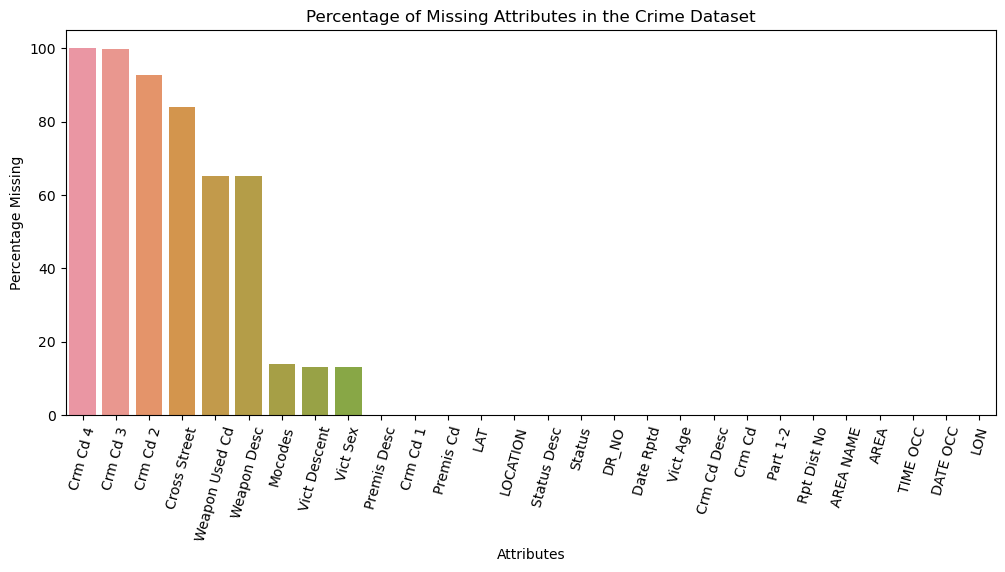

In [216]:
null_fields = (crime_data.isnull().sum()/len(crime_data))*100
null_fields = null_fields.reset_index()
null_fields = null_fields.rename(columns={
    "index": "Attributes", 
    0: "missing_percentage"
    }).sort_values(by=["missing_percentage"], ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=null_fields["Attributes"], y=null_fields["missing_percentage"])
plt.title("Percentage of Missing Attributes in the Crime Dataset")
plt.xlabel("Attributes")
plt.ylabel("Percentage Missing")
plt.xticks(rotation=75)
plt.show()

In [217]:
print("Attributes with more than 80% missing values:")
list(null_fields[null_fields["missing_percentage"] >= 80]["Attributes"].values)

Attributes with more than 80% missing values:


['Crm Cd 4', 'Crm Cd 3', 'Crm Cd 2', 'Cross Street']

<b>Inference:</b> We can remove the attributes with more than `80%` missing values. Also, we can remove the `Cross Street` attribute because we have `LAT` and `LON` attributes to account for the street information. In fact, if required we can use geo-mapping APIs to fetch the street address using the latitude & longitude information.

In [218]:
crime_data.drop(
    ['Crm Cd 4', 'Crm Cd 3', 'Crm Cd 2', 'Cross Street'], 
    axis=1, 
    inplace=True
    )

### Checking for duplicate rows:

In [219]:
duplicate_rows = crime_data.duplicated().sum()
print(f"The number of duplicate rows in the dataset is {duplicate_rows}.")

The number of duplicate rows in the dataset is 0.


### Converting data types:

Here, we can extract the year, month, day and weekday from the datetime attributes from the crime dataset like `Date Rptd` and `DATE OCC`.

In [220]:
crime_data["Date Rptd"] = pd.to_datetime(crime_data["Date Rptd"])
crime_data["Date Rptd Year"] = crime_data["Date Rptd"].dt.year
crime_data["Date Rptd Month"] = crime_data["Date Rptd"].dt.month
crime_data["Date Rptd Day"] = crime_data["Date Rptd"].dt.day
crime_data["Date Rptd Weekday"] = crime_data["Date Rptd"].dt.strftime('%A')

In [221]:
crime_data["DATE OCC"] = pd.to_datetime(crime_data["DATE OCC"])
crime_data["DATE OCC Year"] = crime_data["DATE OCC"].dt.year
crime_data["DATE OCC Month"] = crime_data["DATE OCC"].dt.month
crime_data["DATE OCC Day"] = crime_data["DATE OCC"].dt.day
crime_data["DATE OCC Weekday"] = crime_data["DATE OCC"].dt.strftime('%A')

In [222]:
crime_data["Date Difference"] = (crime_data["Date Rptd"] - crime_data["DATE OCC"]).dt.days

Converting the `TIME OCC` attribute into `AM/PM` format to understand it better.

In [223]:
crime_data["TIME OCC"] = crime_data["TIME OCC"].astype(str).apply(lambda x: x.zfill(4))
crime_data["TIME OCC"] = crime_data["TIME OCC"].str.slice(0, 2) + ":" + crime_data["TIME OCC"].str.slice(2)
crime_data["TIME OCC"] = pd.to_datetime(crime_data["TIME OCC"], format='%H:%M').dt.strftime('%I:%M %p')

Converting the `TIME OCC` attribute into `24` hour format to understand it better and perform visualizations.

In [224]:
time_conv_24f = lambda t: datetime.datetime.strptime(t, '%I:%M %p').strftime('%H:%M')
crime_data['TIME OCC 24H'] = crime_data["TIME OCC"].apply(time_conv_24f)

### Encoding categorical data:

We have categorized the `Crm Cd Desc` from the crime dataset attribute into two different crime types - `Property` and `Violent` based on the crime committed. This helps us to get an overall insight into the general type of crimes happening around the LA city.

In [225]:
crime_type_mapping = {
  'ARSON': 'Property',
  'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': 'Violent', 
  'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'Violent',
  'ATTEMPTED ROBBERY': 'Property',
  'BATTERY - SIMPLE ASSAULT': 'Violent',
  'BATTERY ON A FIREFIGHTER': 'Violent',
  'BATTERY POLICE (SIMPLE)': 'Violent',
  'BATTERY WITH SEXUAL CONTACT': 'Violent',
  'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM': 'Violent',
  'BIKE - ATTEMPTED STOLEN': 'Property',
  'BIKE - STOLEN': 'Property',
  'BLOCKING DOOR INDUCTION CENTER': 'Violent',
  'BOAT - STOLEN': 'Property',
  'BRANDISH WEAPON': 'Violent',
  'BRIBERY': 'Property', 
  'BUNCO, ATTEMPT': 'Property',
  'BUNCO, GRAND THEFT': 'Property',
  'BUNCO, PETTY THEFT': 'Property',
  'BURGLARY': 'Property',
  'BURGLARY FROM VEHICLE': 'Property',
  'BURGLARY FROM VEHICLE, ATTEMPTED': 'Property',
  'BURGLARY, ATTEMPTED': 'Property',
  'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'Violent',
  'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'Violent',
  'CHILD ANNOYING (17YRS & UNDER)': 'Violent',
  'CHILD PORNOGRAPHY': 'Property',
  'CHILD STEALING': 'Property',
  'CONSPIRACY': 'Property',
  'CONTEMPT OF COURT': 'Violent',
  'CONTRIBUTING': 'Property',
  'COUNTERFEIT': 'Property',
  'CREDIT CARDS, FRAUD USE ($950 & UNDER': 'Property',
  'CREDIT CARDS, FRAUD USE ($950.01 & OVER)': 'Property',
  'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'Violent',
  'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)': 'Violent', 
  'CRUELTY TO ANIMALS': 'Violent',
  'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER': 'Property',
  'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01': 'Property',
  'DISCHARGE FIREARMS/SHOTS FIRED': 'Violent',
  'DISHONEST EMPLOYEE - GRAND THEFT': 'Property',
  'DISHONEST EMPLOYEE - PETTY THEFT': 'Property',
  'DISHONEST EMPLOYEE ATTEMPTED THEFT': 'Property',
  'DISRUPT SCHOOL': 'Violent',
  'DISTURBING THE PEACE': 'Violent',
  'DOCUMENT FORGERY / STOLEN FELONY': 'Property',
  'DOCUMENT WORTHLESS ($200 & UNDER)': 'Property',
  'DOCUMENT WORTHLESS ($200.01 & OVER)': 'Property',
  'DRIVING WITHOUT OWNER CONSENT (DWOC)': 'Property',
  'DRUGS, TO A MINOR': 'Violent',
  'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)': 'Property',
  'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)': 'Property',
  'EXTORTION': 'Violent',
  'FAILURE TO DISPERSE': 'Violent',
  'FALSE IMPRISONMENT': 'Violent',
  'GRAND THEFT / AUTO REPAIR': 'Property',
  'GRAND THEFT / INSURANCE FRAUD': 'Property',
  'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS': 'Violent',
  'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE': 'Violent',
  'ILLEGAL DUMPING': 'Property',
  'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)': 'Violent',
  'INCITING A RIOT': 'Violent',
  'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'Violent',
  'INTIMATE PARTNER - SIMPLE ASSAULT': 'Violent',
  'KIDNAPPING': 'Violent', 
  'KIDNAPPING - GRAND ATTEMPT': 'Violent',
  'LEWD/LASCIVIOUS ACTS WITH CHILD': 'Violent',
  'MANSLAUGHTER, NEGLIGENT': 'Violent',
  'ORAL COPULATION': 'Violent',
  'OTHER ASSAULT': 'Violent',
  'PANDERING': 'Violent',
  'PEEPING TOM': 'Violent',
  'PETTY THEFT - AUTO REPAIR': 'Property',
  'PICKPOCKET': 'Property',
  'PICKPOCKET, ATTEMPT': 'Property',
  'PIMPING': 'Violent',
  'PURSE SNATCHING': 'Property',
  'PURSE SNATCHING - ATTEMPT': 'Property',
  'RAPE, ATTEMPTED': 'Violent',
  'RAPE, FORCIBLE': 'Violent',
  'RECKLESS DRIVING': 'Violent',
  'RESISTING ARREST': 'Violent',
  'ROBBERY': 'Violent',
  'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE': 'Violent',
  'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ': 'Violent',
  'SEXUAL PENETRATION W/FOREIGN OBJECT': 'Violent',
  'SHOPLIFTING - ATTEMPT': 'Property',
  'SHOPLIFTING - PETTY THEFT ($950 & UNDER)': 'Property',
  'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)': 'Property',
  'SHOTS FIRED AT INHABITED DWELLING': 'Violent',
  'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT': 'Violent',
  'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH': 'Violent',
  'STALKING': 'Violent',
  'TELEPHONE PROPERTY - DAMAGE': 'Violent',
  'THEFT FROM MOTOR VEHICLE - ATTEMPT': 'Property',
  'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)': 'Property',
  'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)': 'Property',
  'THEFT FROM PERSON - ATTEMPT': 'Property',
  'THEFT OF IDENTITY': 'Property',
  'THEFT PLAIN - ATTEMPT': 'Property',
  'THEFT PLAIN - PETTY ($950 & UNDER)': 'Property',
  'THEFT, COIN MACHINE - ATTEMPT': 'Property',
  'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)': 'Property',
  'THEFT, COIN MACHINE - PETTY ($950 & UNDER)': 'Property',
  'THEFT, PERSON': 'Property',
  'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD': 'Property',
  'THREATENING PHONE CALLS/LETTERS': 'Violent',
  'THROWING OBJECT AT MOVING VEHICLE': 'Violent',
  'TILL TAP - GRAND THEFT ($950.01 & OVER)': 'Property',
  'TILL TAP - PETTY ($950 & UNDER)': 'Property',
  'TRESPASSING': 'Violent',
  'UNAUTHORIZED COMPUTER ACCESS': 'Property',
  'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'Property',
  'VANDALISM - MISDEMEAMEANOR ($399 OR UNDER)': 'Property',
  'VEHICLE - ATTEMPT STOLEN': 'Property',
  'VEHICLE - STOLEN': 'Property',
  'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)': 'Property',
  'VIOLATION OF COURT ORDER': 'Violent',
  'VIOLATION OF RESTRAINING ORDER': 'Violent',
  'VIOLATION OF TEMPORARY RESTRAINING ORDER': 'Violent',
  'WEAPONS POSSESSION/BOMBING': 'Violent'
}

In [226]:
crime_type_map = lambda x: crime_type_mapping.get(x)
crime_data['crime_type_two_class'] = crime_data["Crm Cd Desc"].apply(crime_type_map)

We have categorized the `Weapon Desc` attribute from the crime dataset into various types of weapons such as - `Verbal-Threat`, `Firearms`, `Biochemical`, `Explosives`, `Animals`, `Household-Objects`, `Demand-Note`, `Combat-Weapons`, `Automobile`, `Drugs`, `Medical-Instruments`, `Hand-to-Hand-Combat`, and `General-Instruments`.

In [227]:
weapon_types = {
    'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)': 'Hand-to-Hand-Combat',
    'UNKNOWN WEAPON/OTHER WEAPON': np.nan,
    'VERBAL THREAT': 'Verbal-Threat',
    'HAND GUN': 'Firearms',
    'SEMI-AUTOMATIC PISTOL': 'Firearms',
    'KNIFE WITH BLADE 6INCHES OR LESS': 'General-Instruments',
    'UNKNOWN FIREARM': 'Firearms',
    'OTHER KNIFE': 'General-Instruments',
    'MACE/PEPPER SPRAY': 'General-Instruments',
    'VEHICLE': 'Automobile',
    'ROCK/THROWN OBJECT': 'General-Instruments',
    'PIPE/METAL PIPE': 'General-Instruments',
    'BOTTLE': 'Household-Objects',
    'STICK': 'General-Instruments',
    'FOLDING KNIFE': 'General-Instruments',
    'CLUB/BAT': 'Combat-Weapons',
    'KITCHEN KNIFE': 'General-Instruments',
    'AIR PISTOL/REVOLVER/RIFLE/BB GUN': 'Firearms',
    'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH': 'General-Instruments',
    'BLUNT INSTRUMENT': 'General-Instruments',
    'HAMMER': 'General-Instruments',
    'SIMULATED GUN': 'Firearms',
    'REVOLVER': 'Firearms',
    'MACHETE': 'Combat-Weapons',
    'OTHER FIREARM': 'Firearms',
    'OTHER CUTTING INSTRUMENT': 'General-Instruments',
    'PHYSICAL PRESENCE': 'Hand-to-Hand-Combat',
    'UNKNOWN TYPE CUTTING INSTRUMENT': 'General-Instruments',
    'SCREWDRIVER': 'General-Instruments',
    'CONCRETE BLOCK/BRICK': 'General-Instruments',
    'FIRE': 'Explosives',
    'SCISSORS': 'General-Instruments',
    'BELT FLAILING INSTRUMENT/CHAIN': 'General-Instruments',
    'RIFLE': 'Firearms',
    'FIXED OBJECT': 'General-Instruments',
    'STUN GUN': 'General-Instruments',
    'AXE': 'General-Instruments',
    'GLASS': 'General-Instruments',
    'BOARD': 'General-Instruments',
    'SHOTGUN': 'Firearms',
    'CAUSTIC CHEMICAL/POISON': 'Biochemical',
    'SWITCH BLADE': 'General-Instruments',
    'BRASS KNUCKLES': 'Combat-Weapons',
    'BOMB THREAT': 'Explosives',
    'TOY GUN': 'Firearms',
    'TIRE IRON': 'General-Instruments',
    'SCALDING LIQUID': 'Household-Objects',
    'SWORD': 'Combat-Weapons',
    'RAZOR BLADE': 'General-Instruments',
    'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms',
    'EXPLOSIVE DEVICE': 'Explosives',
    'DIRK/DAGGER': 'Combat-Weapons',
    'ASSAULT WEAPON/UZI/AK47/ETC': 'Firearms',
    'ICE PICK': 'General-Instruments',
    'DEMAND NOTE': 'Demand-Note',
    'LIQUOR/DRUGS': 'Drugs',
    'RAZOR': 'General-Instruments',
    'SEMI-AUTOMATIC RIFLE': 'Firearms',
    'ROPE/LIGATURE': 'General-Instruments',
    'DOG/ANIMAL (SIC ANIMAL ON)': 'Animals',
    'STARTER PISTOL/REVOLVER': 'Firearms',
    'CLEAVER': 'General-Instruments',
    'BOWIE KNIFE': 'Combat-Weapons',
    'SAWED OFF RIFLE/SHOTGUN': 'Firearms',
    'AUTOMATIC WEAPON/SUB-MACHINE GUN': 'Firearms',
    'SYRINGE': 'Medical-Instruments',
    'BOW AND ARROW': 'General-Instruments',
    'STRAIGHT RAZOR': 'General-Instruments',
    'UNK TYPE SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms',
    'MARTIAL ARTS WEAPONS': 'Combat-Weapons',
    'BLACKJACK': 'General-Instruments',
    'RELIC FIREARM': 'Firearms',
    'UZI SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms',
    'ANTIQUE FIREARM': 'Firearms',
    'MAC-11 SEMIAUTOMATIC ASSAULT WEAPON': 'Firearms',
    'MAC-10 SEMIAUTOMATIC ASSAULT WEAPON': 'Firearms',
    'M1-1 SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms',
    'HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms',
    'M-14 SEMIAUTOMATIC ASSAULT RIFLE': 'Firearms'
}

In [228]:
weapontype_mapping = lambda x: weapon_types.get(x)
crime_data['weapon_type'] = crime_data['Weapon Desc'].apply(weapontype_mapping)

We have decoded the `Vict Descent` attribute from the crime dataset to the appropriate ethnic descriptions to present the information in a clear and understandable manner.

In [229]:
race_map = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean',
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    'Z': 'Asian Indian'
}

In [230]:
race_mapping = lambda x: race_map.get(x)
crime_data['Vict Descent Descp'] = crime_data['Vict Descent'].apply(race_mapping)

### Data preprocessing:

According to the crime dataset, demographic factors include attributes such as `Vict Age`(Count: 811663), `Vict Sex`(Count: 705139), and `Vict Descent`(Count: 705131). In order to handle the missing values in `Vict Sex` and `Vict Descent` attributes we can make use of the metadata to fill all the `NaN` values and also to replace the unrecognized values such as `H`(in Vict Sex) with `X` i.e. "Unknown".

Displaying all the unique values present in the `Vict Sex` attribute

In [231]:
sex_values = crime_data['Vict Sex'].unique()
sex_values

array(['F', 'M', 'X', nan, 'H', '-'], dtype=object)

Replacing missing values - `NaN`, `H`, and `-` in `Vict Sex` attribute with `X` i.e. "unknown"

In [232]:
replace_with_X = 'X'
crime_data['Vict Sex'].fillna(replace_with_X, inplace = True)
unrecognized_vict_sex_values = ["H","-"]
crime_data['Vict Sex'] = crime_data['Vict Sex'].replace(unrecognized_vict_sex_values,replace_with_X)

Ensuring that there are no null values in the `Vict Sex` attribute

In [233]:
null_fields_vict_sex = crime_data['Vict Sex'].isnull().sum()
print(f"Null Values Check in Vict Sex Attribute = {null_fields_vict_sex}")

Null Values Check in Vict Sex Attribute = 0


Displaying all the unique values present in the `Vict Descent` attribute

In [234]:
vict_descent_counts = crime_data['Vict Descent'].unique()
print(vict_descent_counts)

['B' 'H' 'X' 'W' 'A' 'O' nan 'C' 'F' 'K' 'I' 'V' 'Z' 'J' 'P' 'S' 'G' 'U'
 'D' 'L' '-']


Replacing missing values - `NaN` and `-` in the `Vict Descent` attribute with `X` i.e. "unknown"

In [235]:
replace_with_X = "X"
crime_data['Vict Descent'].fillna(replace_with_X, inplace = True)
unrecognized_vict_descent_values = ["H","-"]
crime_data['Vict Descent'] = crime_data['Vict Descent'].replace(unrecognized_vict_descent_values,replace_with_X)

Ensuring that there are no null values in the `Vict Descent` attribute

In [236]:
null_fields_vict_sex = crime_data["Vict Descent"].isnull().sum()
print(f"Null Values Check in Vict Descent Attribute = {null_fields_vict_sex}")

Null Values Check in Vict Descent Attribute = 0


## Exploratory Data Analysis

### 1. Overall Crime Trends:

2022    234172
2021    209326
2020    199392
2023    168773
Name: DATE OCC Year, dtype: int64


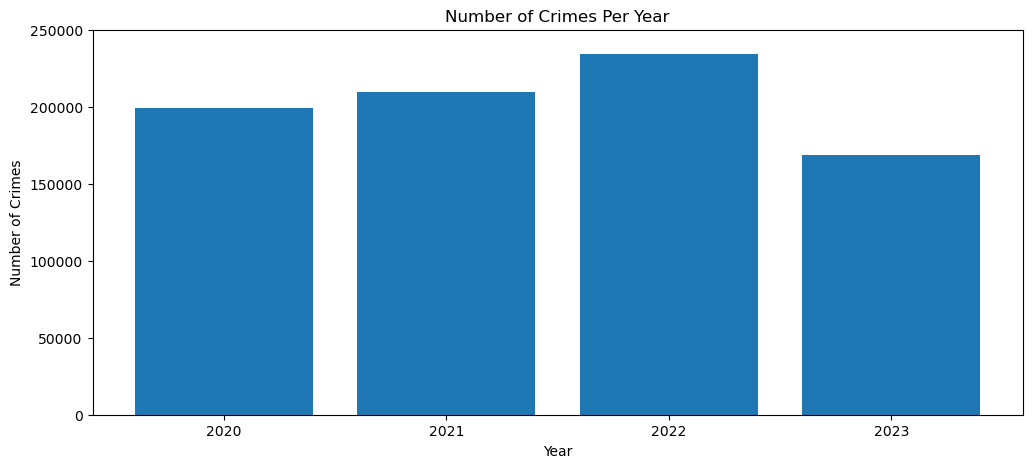

In [248]:
yearly_counts = crime_data["DATE OCC Year"].value_counts()
plt.figure(figsize=(12, 5))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.xticks(range(2020, 2024, 1))
plt.xlabel("Year")
plt.yticks(ticks=range(0, 300000, 50000))
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes Per Year")
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that the total number of crimes was highest during the year 2022 when compared to the remaining years. The trend of the number of crimes has increased steadly from 2020 to 2022, where the incidents of crime recorded is the highest. However, the year 2023 has recorded the lowest number of crimes. This might be because the dataset represents the incidents of crimes, in the city of Los Angeles, starting from January 1, 2020 to October 9, 2023. Hence, there are three more months to occur yet to make a statement about the year 2023.

### 2. Seasonal Patterns:

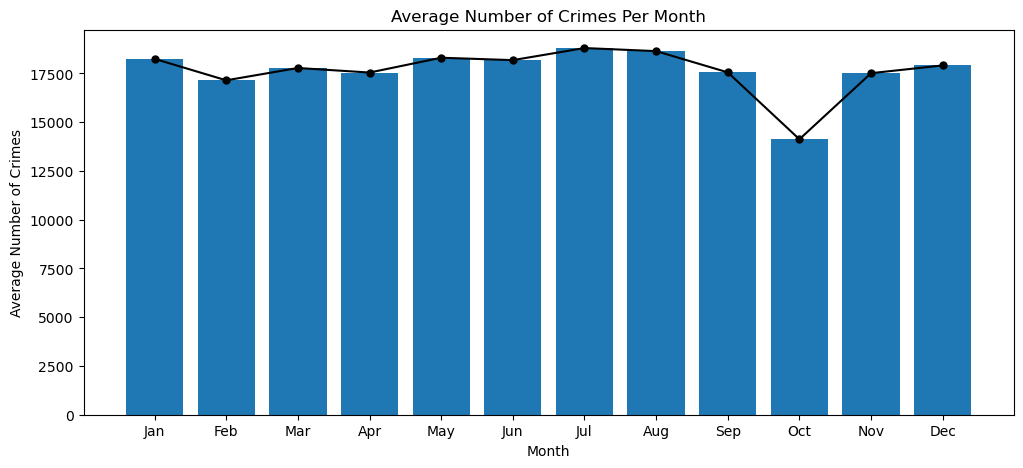

In [251]:
monthly_crime = crime_data.groupby(["DATE OCC Year", "DATE OCC Month"]).size().reset_index(name="crime_count")
average_monthly_crimes = monthly_crime.groupby("DATE OCC Month")["crime_count"].mean()
plt.figure(figsize=(12, 5))
plt.bar(average_monthly_crimes.index, average_monthly_crimes.values)
average_monthly_crimes.plot(kind='line', marker='.', color='black', ms=10)
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Average Number of Crimes")
plt.title("Average Number of Crimes Per Month")
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that the average number of crimes per month was highest during the month of July when compared to the remaining months.

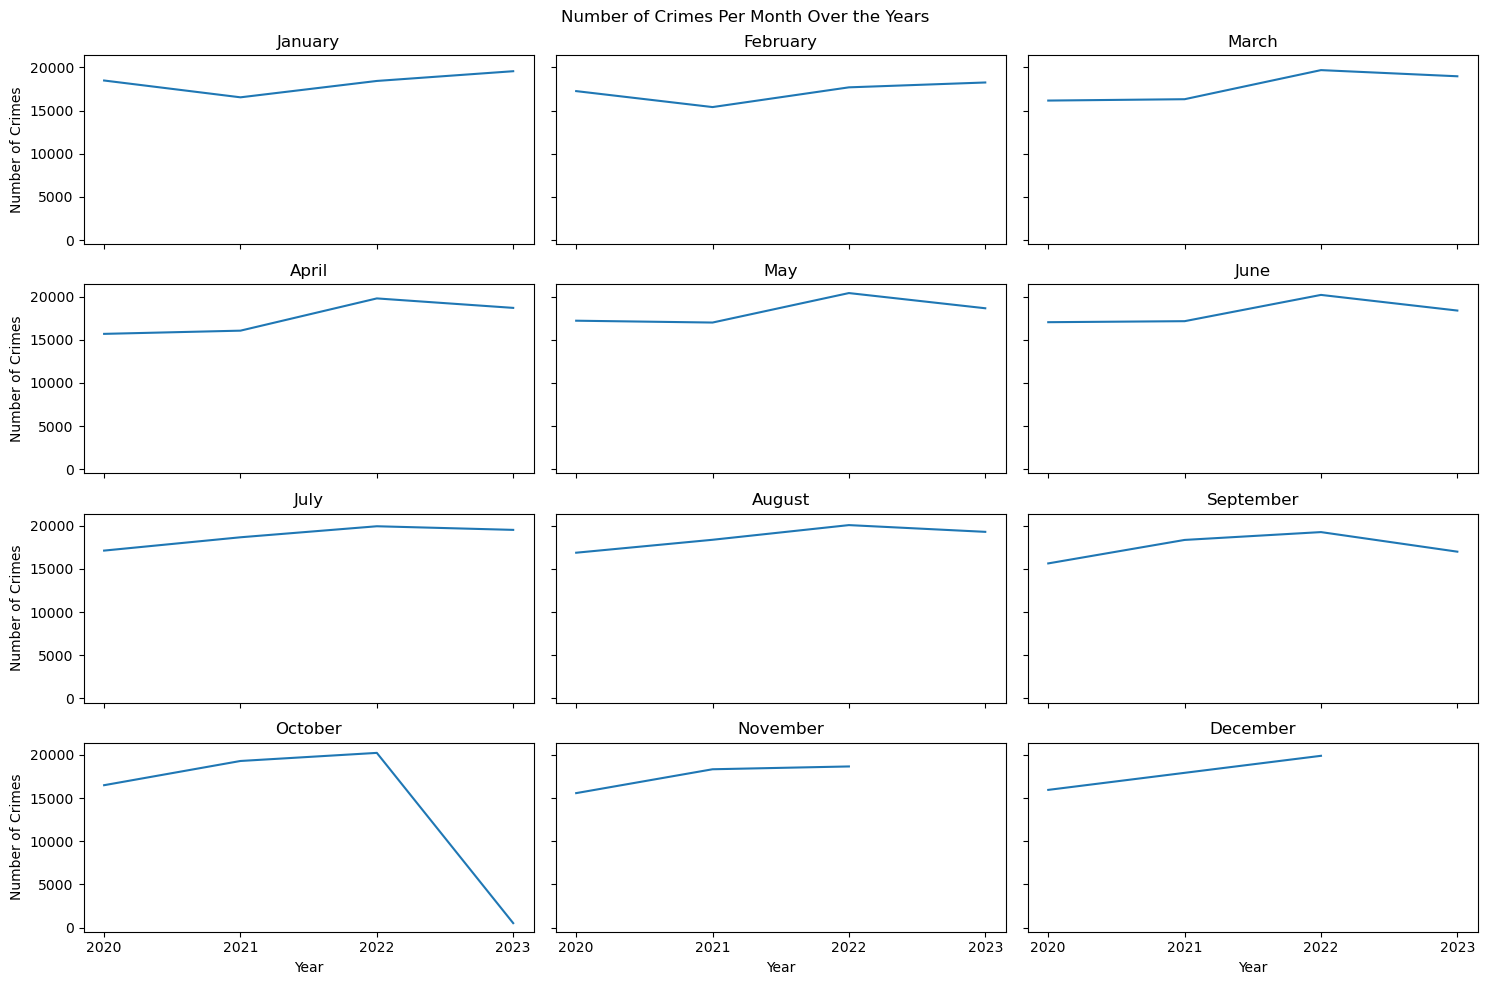

In [239]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Number of Crimes Per Month Over the Years")

months_list = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

for month in range(1, 13):
    row, column = divmod(month - 1, 3)
    ax = axes[row, column]
    
    data = monthly_crime[(monthly_crime["DATE OCC Month"] == month)]
    
    ax.plot(data["DATE OCC Year"], data["crime_count"])
    
    if row == 3:
        ax.set_xlabel("Year")
    if column == 0:
        ax.set_ylabel("Number of Crimes")
    ax.set_title(f"{months_list[month-1]}")
    ax.set_xticks(range(2020, 2024, 1))

plt.tight_layout()
plt.show()

<b>Inference:</b> It can be noted from the above line plots that the number of crimes in each month over the years follow a similar pattern. However, we can notice a decline in the number of crimes in the month of October and no crimes in the months of November and December for the year 2023 because the dataset represents the incidents of crime in the city of Los Angeles starting from January 1, 2020, until October 9, 2023.

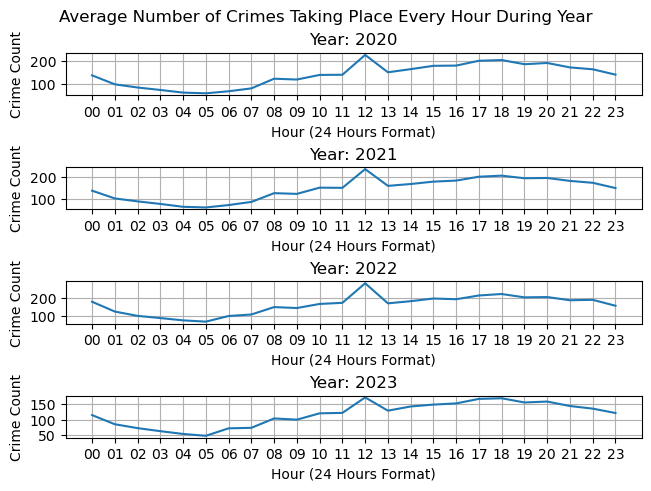

In [255]:
x = crime_data.groupby(by=['DATE OCC Year','TIME OCC 24H']).size().reset_index().rename(columns={
    'DATE OCC Year': 'Year', 'TIME OCC 24H': 'Time', 0: 'Counts'})

getHour = lambda x: datetime.datetime.strptime(x, '%H:%M').strftime('%H')
x['Hour'] = x['Time'].apply(getHour)

year = 2020
fig, axs = plt.subplots(4, 1, layout='constrained')
fig.suptitle('Average Number of Crimes Taking Place Every Hour During Year')
for ax in axs:
    yfilter = x['Year'] == year
    y = x[yfilter][['Hour', 'Counts']]
    k = y.groupby('Hour').mean()
    ax.plot(k)
    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Hour (24 Hours Format)')
    ax.set_ylabel('Crime Count')
    ax.grid(True)
    year += 1

plt.show()

<b>Inference:</b> Most of the crimes seem to take place at `12:00 PM` in the noon in broad daylight and this trend seems consistent across multiple years. However, in the year 2022, there is a notable increase in criminal activity starting from `5:00 AM` early in the morning and it continues to rise till `12:00 PM` in the noon.

### 3. Most Common Crime Type:

The most common crime type is VEHICLE - STOLEN with a frequency of 86816.
The least common crime type is INCITING A RIOT with a frequency of 1.


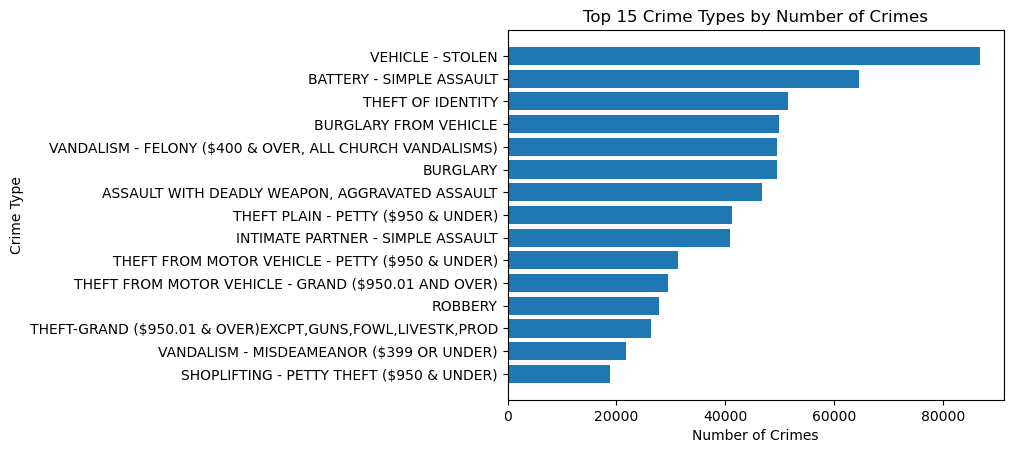

In [241]:
crime_types_counts = crime_data["Crm Cd Desc"].value_counts()
top_crime_types_counts = crime_types_counts.head(15)
print(f"The most common crime type is {crime_types_counts.index[0]} with a frequency of {crime_types_counts.values[0]}.")
print(f"The least common crime type is {crime_types_counts.index[137]} with a frequency of {crime_types_counts.values[137]}.")
top_crime_types_counts_sorted = top_crime_types_counts.sort_values(ascending=True)

plt.barh(top_crime_types_counts_sorted.index, top_crime_types_counts_sorted.values)
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.title("Top 15 Crime Types by Number of Crimes")
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that `VEHICLE - STOLEN` is the most frequently occurring crime type, with 87,356 incidents reported when compared to the remaining crime types. This indicates that vehicle theft is a serious issue in the city of Los Angeles. Whereas, the crime type with the lowest occurrence was `INCITING A RIOT` with just one incident reported.

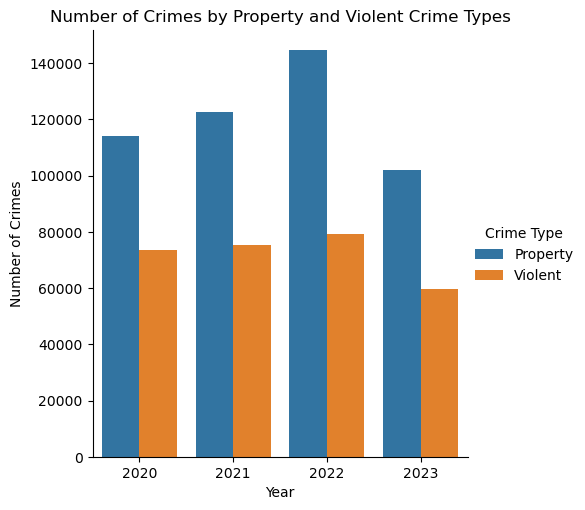

In [242]:
x = crime_data.groupby(['DATE OCC Year', 'crime_type_two_class']).size()
x = x.reset_index(name='counts').rename(columns={
    'DATE OCC Year': 'year', 'crime_type_two_class': 'Crime Type',
    })

sns.catplot(x='year', y='counts', hue='Crime Type', data=x, kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Property and Violent Crime Types')
plt.show()

<b>Inference:</b> Again, the trend of property crimes & violence crimes keep increasing from the years 2020 to 2022. The rate of increase in property crimes for the year 2022, have increased drastically from 2021. Whereas the rate of increase in violent crimes has been pretty much the same over the years. Again, cannot completely make a statement about 2023 as we don't have a complete picture yet. However, it can still be said that it will be similar to the years 2020 and 2021.

### 4. Regional Differences:

Number of Crimes by Geographic Areas:
 AREA   AREA NAME  Number of Crimes
    1     Central             54556
    2     Rampart             37912
    3   Southwest             45386
    4  Hollenbeck             30482
    5      Harbor             33618
    6   Hollywood             43046
    7    Wilshire             38505
    8     West LA             37255
    9    Van Nuys             34454
   10 West Valley             33997
   11   Northeast             35058
   12 77th Street             51316
   13      Newton             40620
   14     Pacific             47491
   15 N Hollywood             40340
   16    Foothill             27106
   17  Devonshire             32936
   18   Southeast             41393
   19     Mission             32310
   20     Olympic             40937
   21     Topanga             32945


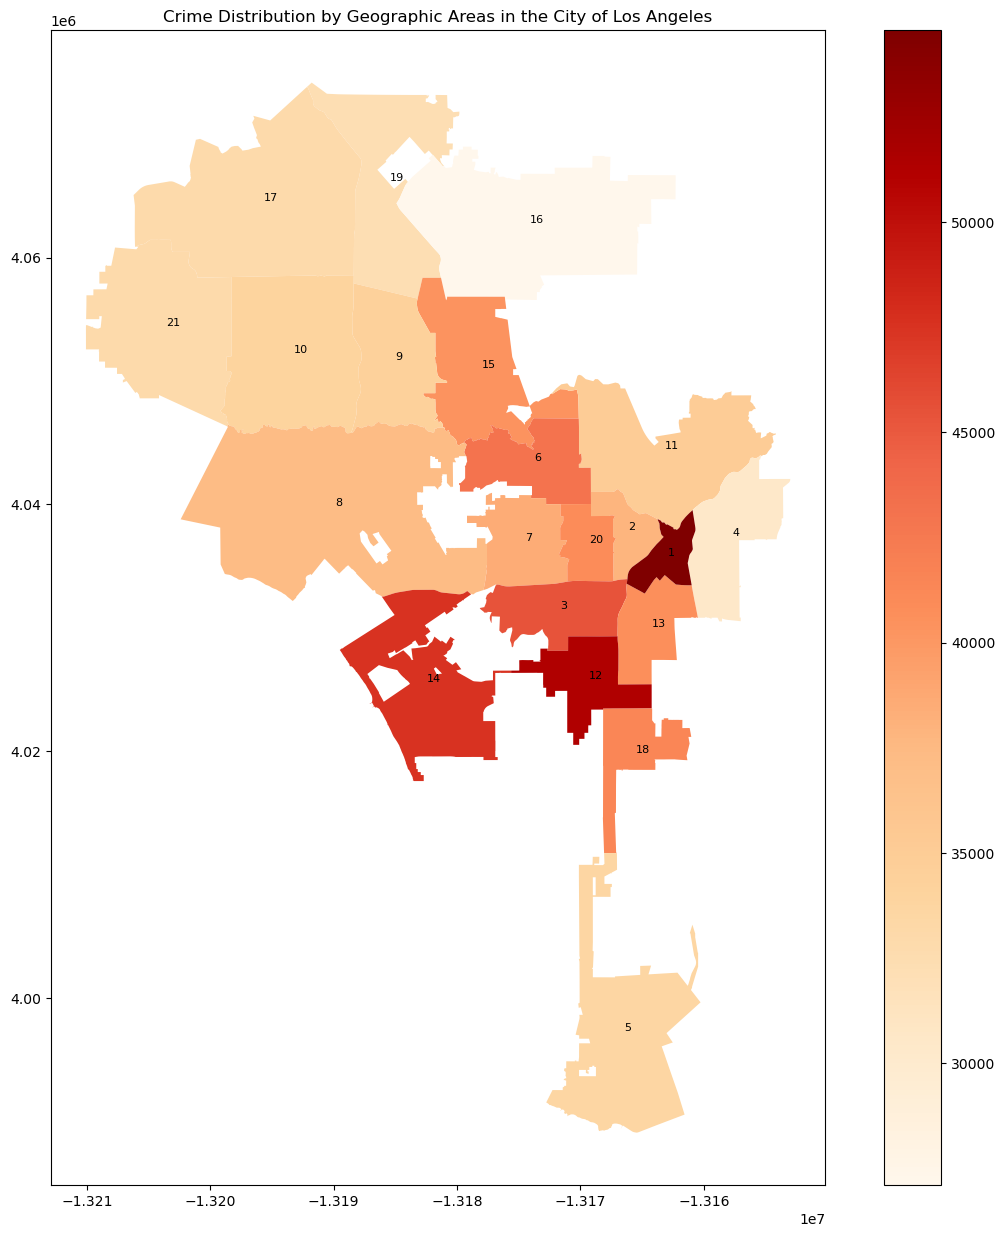

In [256]:
lapd_divisions = gpd.read_file("LAPD_Divisions.shp")

crimes_per_area = crime_data["AREA"].value_counts()
crimes_per_area_df = pd.DataFrame({"PREC": crimes_per_area.index, "Number of Crimes": crimes_per_area.values})
merged_crime_data = lapd_divisions.merge(crimes_per_area_df, on="PREC")
merged_crime_data = merged_crime_data.to_crs("EPSG:3857")

ax = merged_crime_data.plot(column="Number of Crimes", cmap="OrRd", legend=True, figsize=(15, 15))

for x, y, label in zip(merged_crime_data.geometry.centroid.x, merged_crime_data.geometry.centroid.y, merged_crime_data["PREC"]):
    ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords='offset points', fontsize=8)

ax.set_title("Crime Distribution by Geographic Areas in the City of Los Angeles")

lapd_police_precinct = crime_data.groupby(["AREA", "AREA NAME"]).size().reset_index(name="Number of Crimes")
print(f"Number of Crimes by Geographic Areas:\n{lapd_police_precinct.to_string(index=False)}")

<b>Inference:</b> The city of Los Angeles is divided into 21 Geographic Areas or Patrol Divisions by the Los Angeles Police Department (LAPD). It has been noted from the above geographic heat map that the number of crimes was highest in `Area 1 - Central` with 54,841 incidents reported. This indicates that Central Los Angeles experiences a relatively high level of criminal activity when compared to other areas. On the other hand, `Area 16 - Foothill` had the lowest number of crimes with only 27,225 incidents reported. This suggests that Foothill is one of the safer areas in terms of crime rates within Los Angeles.

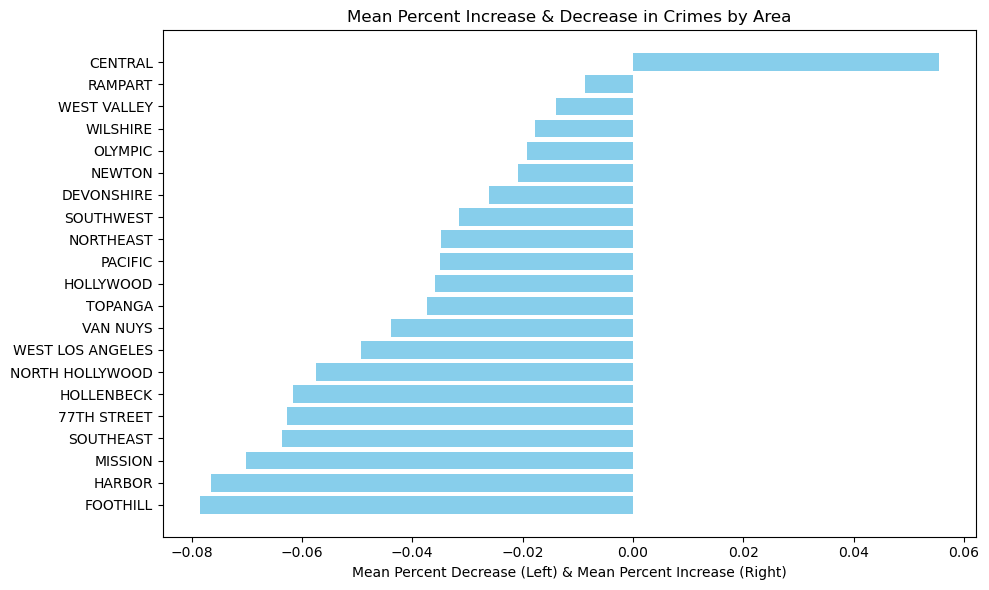

In [260]:
x = pd.merge(crime_data, lapd_divisions, left_on='AREA', right_on='PREC')
x = x[['APREC', 'DATE OCC Year']].rename(columns={'APREC': 'area_name', 'DATE OCC Year': 'year'})
x = x.groupby(['year', 'area_name']).size().reset_index(name='crime_counts')
la_areas = np.unique(x['area_name'])

mean_percent_change = []
for a in la_areas:
    mean_percent_change.append(x[x['area_name'] == a]['crime_counts'].pct_change(periods=1).mean())

area_perchange_df = pd.DataFrame({'area_name': la_areas, 'mean_percent_inc': mean_percent_change})
area_perchange_df = area_perchange_df.sort_values(['mean_percent_inc'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(area_perchange_df['area_name'], area_perchange_df['mean_percent_inc'], color='skyblue')
plt.xlabel('Mean Percent Decrease (Left) & Mean Percent Increase (Right)')
plt.title('Mean Percent Increase & Decrease in Crimes by Area')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<b>Inference:</b> The above plot shows the regions with their mean percentage increase & decrease in crimes from 2020 to 2023. The crimes in `Central` area have drastically increased over the years where as the crimes in the areas like `Foothill`, & `Harbor` have drastically decreased.

In [245]:
female_victim_filter = crime_data[crime_data['Vict Sex'] == 'F']
female_victims_area = female_victim_filter['AREA'].value_counts().reset_index(name='crime-counts').rename(columns={'index': 'PREC'})
female_victims_area_df = lapd_divisions.merge(female_victims_area, on="PREC", how='right')

fig = px.line_polar(female_victims_area_df, 
                    r='crime-counts', 
                    theta='APREC', 
                    line_close=True,
                    title="Crime Distribution by Geographic Areas of LAPD for Female Victims Over the Years"
                   )
fig.update_traces(
    fill='toself', 
    name='Area names'
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<b>Inference:</b> It can be noted from the above polar line plot that the number of crimes faced by female victims was highest in `Area 12 - 77th Street` when compared to the remaining areas.

In [246]:
male_victim_filter = crime_data[crime_data['Vict Sex'] == 'M']
male_victims_area = male_victim_filter['AREA'].value_counts().reset_index(name='crime-counts').rename(columns={'index': 'PREC'})
male_victims_area_df = lapd_divisions.merge(male_victims_area, on="PREC", how='right')

fig = px.line_polar(male_victims_area_df, 
                    r='crime-counts', 
                    theta='APREC', 
                    line_close=True,
                    title="Crime Distribution by Geographic Areas of LAPD for Male Victims Over the Years"
                   )
fig.update_traces(
    fill='toself', 
    name='Area names'
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<b>Inference:</b> It can be noted from the above polar line plot that the number of crimes faced by male victims was highest in `Area 1 - Central` when compared to the remaining areas.

### 5. Correlation with Economic Factors:

Here we made use of three factors: `Mean per capital income`, `population below poverty line`, `unemployment`, and `employment` for the years 2020, 2021, 2023. `Scatter plots` & `Correlation coefficient` was used to show the strength of association between economic factors & number of crimes per year. The data was derived from the [US Census Bureau website](https://data.census.gov/profile/Los_Angeles_city,_California?g=160XX00US0644000). 

In [318]:
economic_fac_df = pd.read_csv('economic-data/economic-factors-by-race.csv')
employment_df =  pd.read_csv('economic-data/LA-city-Employment.csv')
unemployment_df =  pd.read_csv('economic-data/LA-city-Unemployment.csv')

In [262]:
economic_fac_df['mean-percapita-income($)'] = economic_fac_df['mean-percapita-income($)'].apply(lambda x: int(x[1:].replace(',', '')[0:-3]))
employment_df['Month'] = employment_df['Period'].apply(lambda x: int(x[1:]))
unemployment_df['Month'] = unemployment_df['Period'].apply(lambda x: int(x[1:]))

In [263]:
economic_fac_df.head()

,race,year,population,percent-below-poverty,population-below-poverty,mean-percapita-income($)
0,total,2022,3822224.0,16.60%,634489.184,45270
1,total,2021,3849306.0,17.20%,662080.632,39509
2,total,2020,3898747.0,17.00%,662786.990,37143
3,White alone,2020,1359068.0,14.30%,194346.724,47310
4,Black or African American alone,2020,336096.0,24.50%,82343.520,31252


In [264]:
employment_df.head()

,Series ID,Year,Period,Label,Value,Month
0,LAUCT064400000000005,2020,M01,2020 Jan,2057801,1
1,LAUCT064400000000005,2020,M02,2020 Feb,2069580,2
2,LAUCT064400000000005,2020,M03,2020 Mar,1924807,3
3,LAUCT064400000000005,2020,M04,2020 Apr,1628634,4
4,LAUCT064400000000005,2020,M05,2020 May,1558545,5


In [265]:
unemployment_df.head()

,Series ID,Year,Period,Label,Value,Month
0,LAUCT064400000000004,2020,M01,2020 Jan,106115,1
1,LAUCT064400000000004,2020,M02,2020 Feb,105913,2
2,LAUCT064400000000004,2020,M03,2020 Mar,138438,3
3,LAUCT064400000000004,2020,M04,2020 Apr,337923,4
4,LAUCT064400000000004,2020,M05,2020 May,368805,5


In [320]:
yearly_crimes = crime_data.groupby('DATE OCC Year')['DR_NO'].size().reset_index(name='crimes-per-year').rename(columns={'DATE OCC Year': 'year'})
yearly_mean_percapital_income = economic_fac_df[economic_fac_df['race'] == 'total'][['mean-percapita-income($)', 'year']]
yearly_pop_under_poverty = economic_fac_df[economic_fac_df['race'] == 'total'][['population-below-poverty', 'year']]
yearly_property_crimes = crime_data[crime_data['crime_type_two_class'] == 'Property'].groupby('DATE OCC Year')['DR_NO'].size().reset_index(name='crimes-per-year')
yearly_property_crimes.rename(columns={'DATE OCC Year': 'year'}, inplace=True)
yearly_violent_crimes = crime_data[crime_data['crime_type_two_class'] == 'Violent'].groupby('DATE OCC Year')['DR_NO'].size().reset_index(name='crimes-per-year')
yearly_violent_crimes.rename(columns={'DATE OCC Year': 'year'}, inplace=True)

Correlation of `Crimes per year` vs `Mean percapita income`

In [267]:
percap_income_vs_crimes = pd.merge(yearly_mean_percapital_income, yearly_crimes, on='year').sort_values(by=['year'])
percap_income_vs_crimes

,mean-percapita-income($),year,crimes-per-year
2,37143,2020,199392
1,39509,2021,209326
0,45270,2022,234172


In [268]:
percap_income_vs_crimes.drop('year', axis=1).corr()

,mean-percapita-income($),crimes-per-year
mean-percapita-income($),1.000000,0.999982
crimes-per-year,0.999982,1.000000


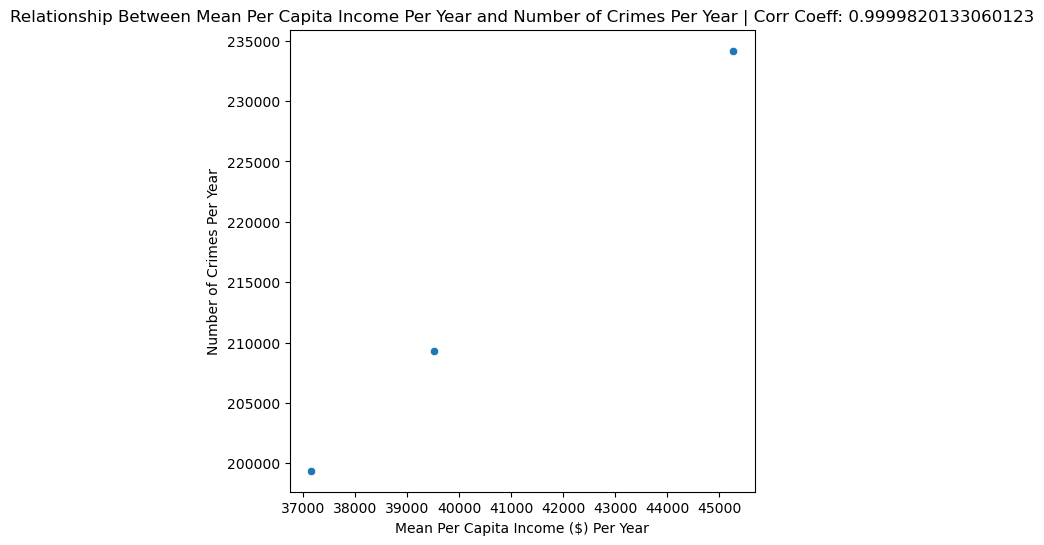

In [269]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=percap_income_vs_crimes['mean-percapita-income($)'], y=percap_income_vs_crimes['crimes-per-year'])
c = percap_income_vs_crimes[['mean-percapita-income($)', 'crimes-per-year']].corr()['crimes-per-year'].values[0]
plt.xlabel('Mean Per Capita Income ($) Per Year')
plt.ylabel('Number of Crimes Per Year')
plt.title(f'Relationship Between Mean Per Capita Income Per Year and Number of Crimes Per Year | Corr Coeff: {c}')
plt.show()

<b>Inference:</b> It is observed in the LA City, as the mean per capita income per year increases, the number of crimes increases. The correlation coefficient of `0.99` indicates that high per-capita income leads to more crimes in the city. This supports the idea that as the general population is getting wealthier, the crimes against them keep increasing. 

Correlation of `Crimes per year` vs `Population below poverty line`

In [270]:
poverty_vs_crimes = pd.merge(yearly_pop_under_poverty, yearly_crimes, on='year').sort_values(by=['year'])
poverty_vs_crimes.drop(['year'], axis=1).corr()

,population-below-poverty,crimes-per-year
population-below-poverty,1.000000,-0.966634
crimes-per-year,-0.966634,1.000000


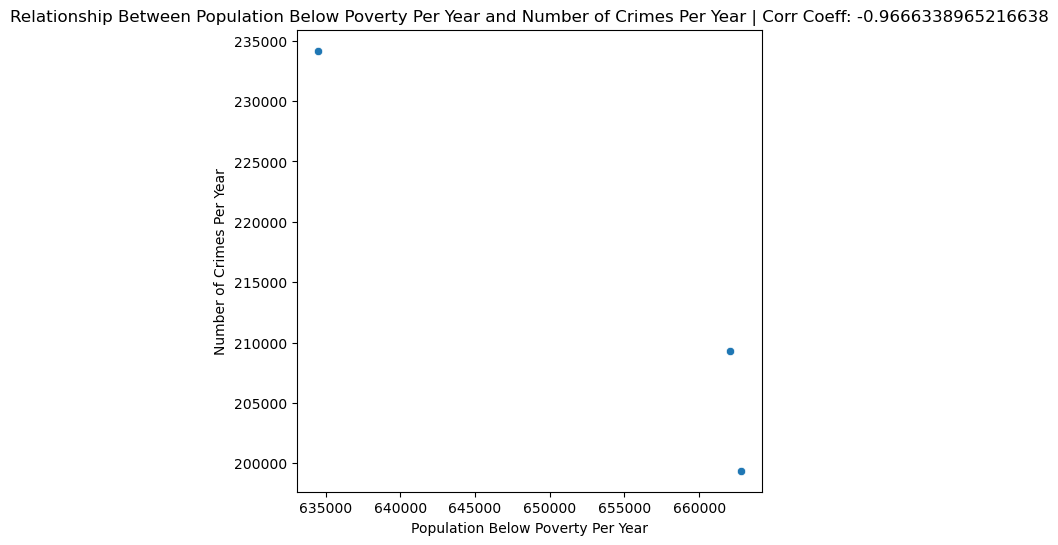

In [271]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=poverty_vs_crimes['population-below-poverty'], y=poverty_vs_crimes['crimes-per-year'])
c = poverty_vs_crimes[['population-below-poverty', 'crimes-per-year']].corr()['crimes-per-year'].values[0]
plt.xlabel('Population Below Poverty Per Year')
plt.ylabel('Number of Crimes Per Year')
plt.title(f'Relationship Between Population Below Poverty Per Year and Number of Crimes Per Year | Corr Coeff: {c}')
plt.show()

<b>Inference:</b> It is observed in the LA City, as the Population below poverty per year increases, the number of crimes in the city decreases. The correlation coefficient of `-0.96` indicates as the population below poverty line increases, number of crimes decreases.

In [272]:
crimes_per_month = crime_data.groupby(['DATE OCC Month', 'DATE OCC Year']).size().reset_index(name='crime-occured').rename(columns={'DATE OCC Month': 'Month', 'DATE OCC Year': 'Year'})
x = pd.merge(crimes_per_month, employment_df[['Month', 'Year', 'Value']], on=['Month', 'Year']).rename(columns={'Value': 'employed'})
emp_and_crime_df = pd.merge(x, unemployment_df[['Month', 'Year', 'Value']], on=['Month', 'Year']).rename(columns={'Value': 'unemployed'})

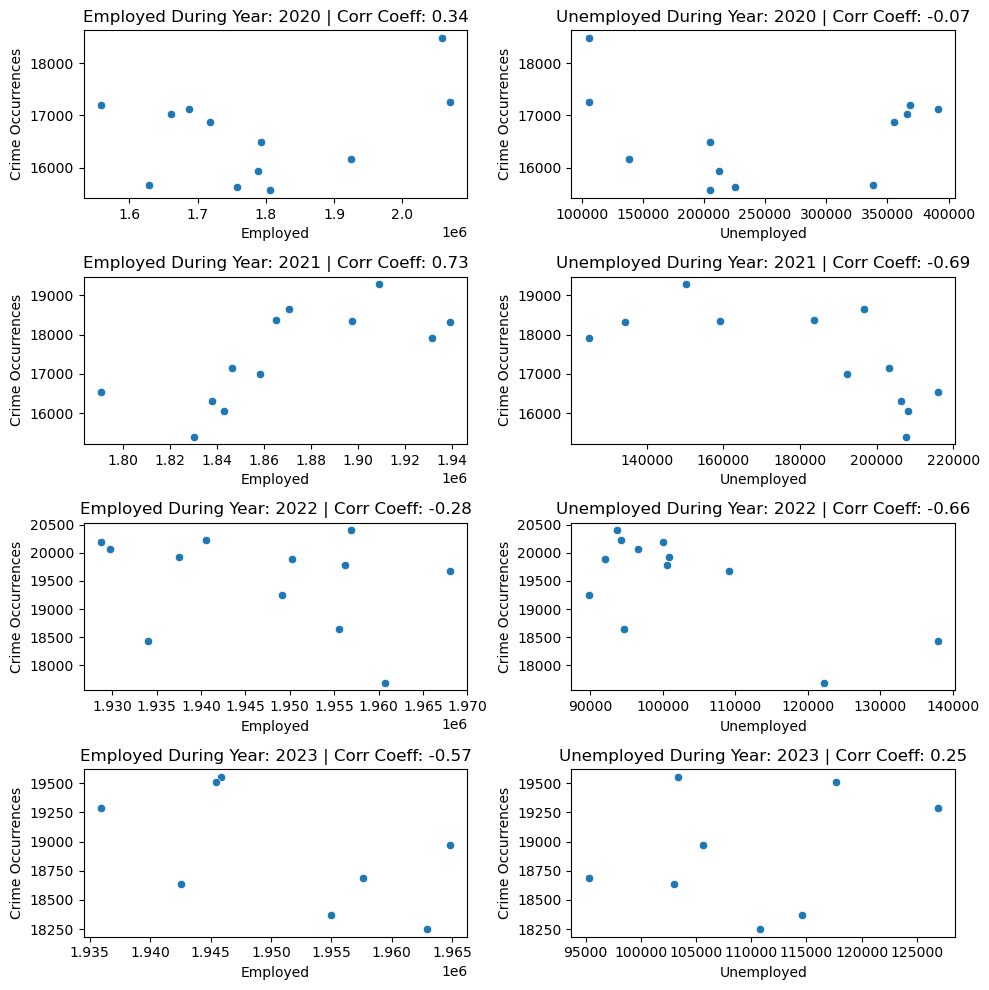

In [273]:
year = 2020
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
for row in range(4):
    kfilter = emp_and_crime_df['Year'] == year
    k = emp_and_crime_df[kfilter]
    p = sns.scatterplot(ax=axes[row, 0], x=k['employed'], y=k['crime-occured'])
    corr_k = round(k[["employed", "crime-occured"]].corr()["crime-occured"].values[0], 2)
    p.set(title=f'Employed During Year: {year} | Corr Coeff: {corr_k}')
    p.set_xlabel('Employed')
    p.set_ylabel('Crime Occurrences')
    p = sns.scatterplot(ax=axes[row, 1], x=k['unemployed'], y=k['crime-occured'])
    corr_k = round((k[["unemployed", "crime-occured"]].corr()["crime-occured"].values[0]),2)
    p.set(title=f'Unemployed During Year: {year} | Corr Coeff: {corr_k}')
    p.set_xlabel('Unemployed')
    p.set_ylabel('Crime Occurrences')
    year += 1
    
plt.tight_layout()

<b>Inference:</b> As we see the correlation between employment & unemployment with number of crimes, we notice that in 2021, the number of crimes increases as employment increases, whereas number of crimes reduces as unemployment increases. Also, in 2023 the number of crimes reduces as employment increases.

### 6. Day of the Week Analysis:

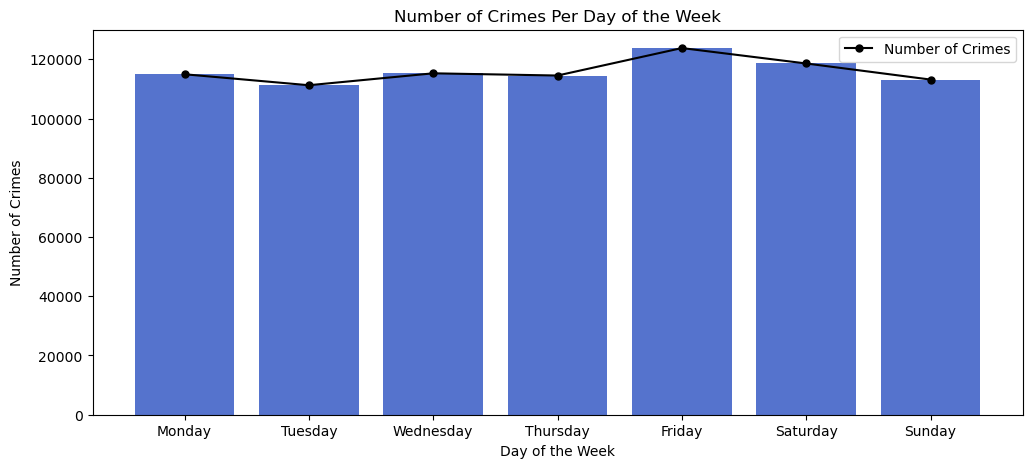

In [274]:
weekday_counts = crime_data["DATE OCC Weekday"].value_counts()
weekday_counts_df = pd.DataFrame({"Weekday": weekday_counts.index, "Number of Crimes": weekday_counts.values})

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(12, 5))
ax = sns.barplot(data=weekday_counts_df, x="Weekday", y="Number of Crimes", order=day_order, color="royalblue")

weekday_counts_df = weekday_counts_df.set_index("Weekday").loc[day_order].reset_index()

weekday_counts_df.plot(x="Weekday", y="Number of Crimes", kind='line', marker='.', color='black', ms=10, ax=ax)
plt.xlabel("Day of the Week")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes Per Day of the Week")
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that the total number of crimes per day of the week was highest on Friday when compared to the remaining days of the week.

<Figure size 1000x500 with 0 Axes>

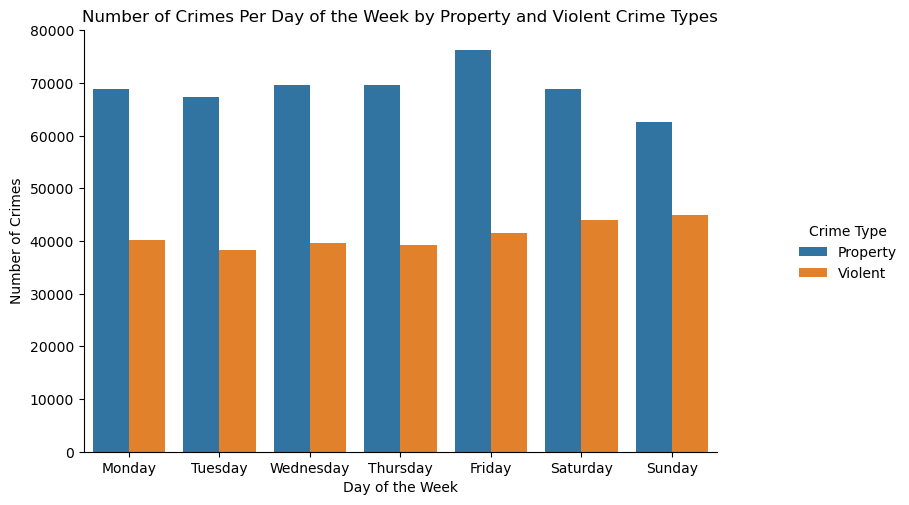

In [275]:
x = crime_data.groupby(['DATE OCC Weekday', 'crime_type_two_class']).size()
x = x.reset_index(name='counts').rename(columns={
    'DATE OCC Weekday': 'weekday', 'crime_type_two_class': 'Crime Type',
    })

plt.figure(figsize=(10, 5))
sns.catplot(x='weekday', y='counts', hue='Crime Type', data=x, kind='bar', order=day_order).fig.set_size_inches(10, 5)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Per Day of the Week by Property and Violent Crime Types')
plt.show()

<b>Inference:</b> It can be noted from the above grouped bar graph that number of property crimes was highest on Friday when compared to the remaning days of the week. The property crime trend keeps increasing from Tuesday to Friday. Similary, the incidents of violent crimes was highest on Sunday when compared to the remaning days of the week.

#### Further analysis of property crimes on Friday by the type of weapon used on the committing the crime:

In [276]:
property_friday_crimes = crime_data[(crime_data['DATE OCC Weekday'] == 'Friday') & (crime_data['crime_type_two_class'] == 'Property')]
property_friday_crimes = property_friday_crimes['weapon_type'].value_counts(normalize=True).reset_index(name='Percent of weapon types reported')
property_friday_crimes.rename(columns={'index': 'Type of Weapon'}, inplace=True)

In [277]:
fig = px.line_polar(property_friday_crimes, 
                    r='Percent of weapon types reported', 
                    theta='Type of Weapon', 
                    line_close=True,
                    title="Percentage of Property Crimes on Fridays by Weapon Type"
                   )
fig.update_traces(
    fill='toself', 
    name='Type of weapons'
    )
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    paper_bgcolor="LightSteelBlue",
    )
fig.update_polars(radialaxis_tickformat='%')
fig.show()

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [278]:
list(np.unique(crime_data[crime_data['weapon_type']=='Hand-to-Hand-Combat']['Weapon Desc']))

['PHYSICAL PRESENCE', 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)']

<b>Inference:</b> On Fridays, we notice that mostly `PHYSICAL PRESENCE` & `STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)` has be used to commit a property crime.

#### Further analysis of violent crimes on Sunday by the type of weapon used on the committing the crime:

In [279]:
violent_sunday_crimes = crime_data[(crime_data['DATE OCC Weekday'] == 'Sunday') & (crime_data['crime_type_two_class'] == 'Violent')]
violent_sunday_crimes = violent_sunday_crimes['weapon_type'].value_counts(normalize=True).reset_index(name='Percent of weapon types reported')
violent_sunday_crimes.rename(columns={'index': 'Type of Weapon'}, inplace=True)

In [280]:
fig = px.line_polar(violent_sunday_crimes, 
                    r='Percent of weapon types reported', 
                    theta='Type of Weapon', 
                    line_close=True,
                    title="Percentage of Violent Crimes on Sundays by Weapon Type"
                   )
fig.update_traces(
    fill='toself', 
    name='Type of weapons'
    )
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    paper_bgcolor="LightSteelBlue",
    )
fig.update_polars(radialaxis_tickformat='%')
fig.show()

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<b>Inference:</b> On Sundays, we notice that mostly PHYSICAL PRESENCE & STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE) has be used to commit a violent crime.

### 7. Impact of Major Events:

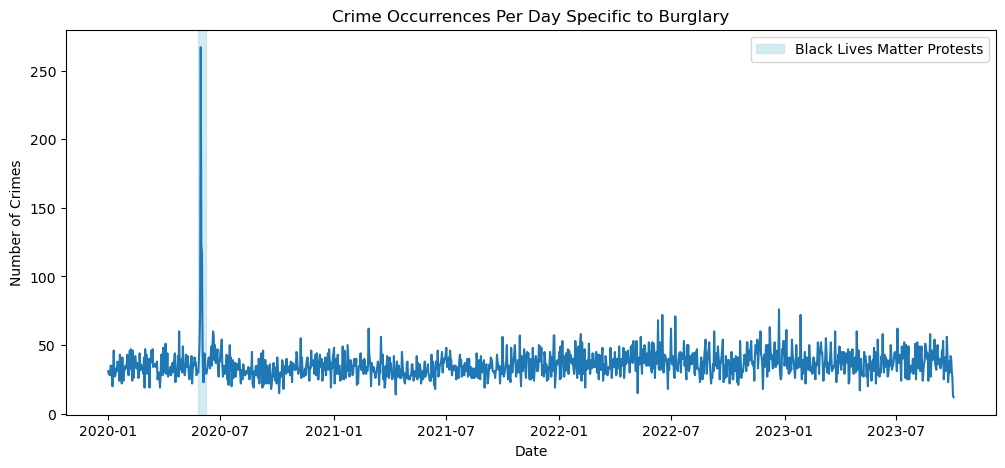

In [281]:
burglary_values_filter = ["BURGLARY"]
burglary_filter = crime_data[crime_data["Crm Cd Desc"].isin(burglary_values_filter)]

burglary_date_occ_counts = burglary_filter["DATE OCC"].value_counts()
burglary_date_occ_counts_df = pd.DataFrame({"Date": burglary_date_occ_counts.index, "Number of Crimes (Burglary)": burglary_date_occ_counts.values})

plt.figure(figsize=(12, 5))
plt.title("Crime Occurrences Per Day Specific to Burglary")
crimes_by_day = sns.lineplot(data=burglary_date_occ_counts_df, x="Date", y="Number of Crimes (Burglary)")
crimes_by_day.set_ylabel("Number of Crimes")

start_date = datetime.datetime.strptime('2020-05-26', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2020-06-07', "%Y-%m-%d")

plt.axvspan(start_date, end_date, alpha=0.5, color='lightblue', label='Black Lives Matter Protests')

plt.legend()
plt.show()

<b>Inference:</b> It can be noted from the above chart that there is a significant increase in burglary crimes during the period of May 26, 2020, until June 7, 2020. This coincides with the timeframe of Black Lives Matter Protests in the city of Los Angeles. This suggests a potential link between the protest and an increase in burglary crimes in the city.

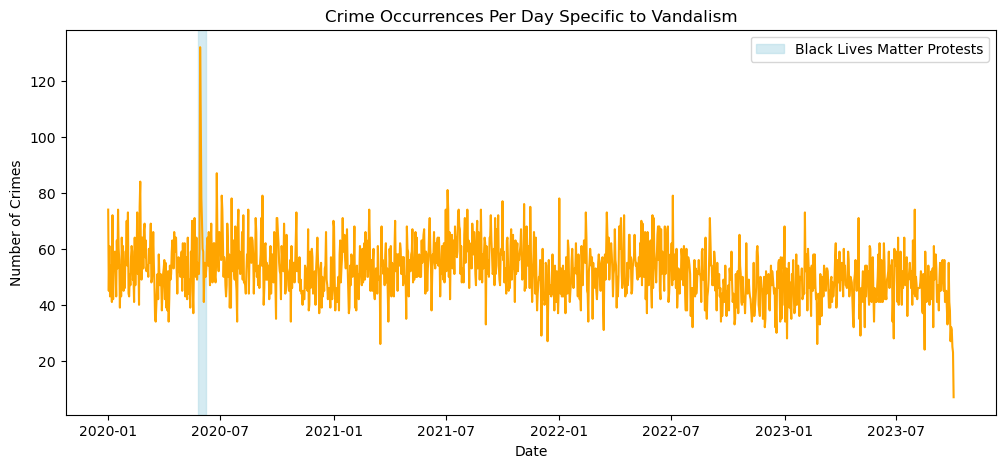

In [282]:
vandalism_values_filter = ["VANDALISM - MISDEAMEANOR ($399 OR UNDER)", "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)"]
vandalism_filter = crime_data[crime_data["Crm Cd Desc"].isin(vandalism_values_filter)]

vandalism_date_occ_counts = vandalism_filter["DATE OCC"].value_counts()
vandalism_date_occ_counts_df = pd.DataFrame({"Date": vandalism_date_occ_counts.index, "Number of Crimes (Vandalism)": vandalism_date_occ_counts.values})

plt.figure(figsize=(12, 5))
plt.title("Crime Occurrences Per Day Specific to Vandalism")
crimes_by_day = sns.lineplot(data=vandalism_date_occ_counts_df, x="Date", y="Number of Crimes (Vandalism)", color="orange")
crimes_by_day.set_ylabel("Number of Crimes")

start_date = datetime.datetime.strptime('2020-05-26', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2020-06-07', "%Y-%m-%d")

plt.axvspan(start_date, end_date, alpha=0.5, color='lightblue', label='Black Lives Matter Protests')

plt.legend()
plt.show()

<b>Inference:</b> It can be noted from the above chart that there is a significant increase in vandalism-related crimes during the period of May 26, 2020, until June 7, 2020. This coincides with the timeframe of Black Lives Matter Protests in the city of Los Angeles. This suggests a potential link between the protest and an increase in vandalism-related incidents in the city.

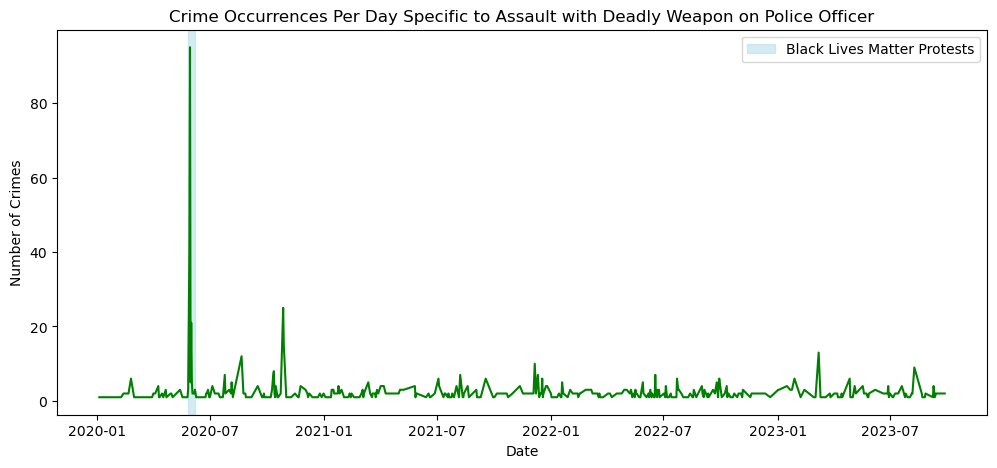

In [283]:
assault_values_filter = ["ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER"]
assault_filter = crime_data[crime_data["Crm Cd Desc"].isin(assault_values_filter)]

assault_date_occ_counts = assault_filter["DATE OCC"].value_counts()
assault_date_occ_counts_df = pd.DataFrame({"Date": assault_date_occ_counts.index, "Number of Crimes (Assault)": assault_date_occ_counts.values})

plt.figure(figsize=(12, 5))
plt.title("Crime Occurrences Per Day Specific to Assault with Deadly Weapon on Police Officer")
crimes_by_day = sns.lineplot(data=assault_date_occ_counts_df, x="Date", y="Number of Crimes (Assault)", color="green")
crimes_by_day.set_ylabel("Number of Crimes")

start_date = datetime.datetime.strptime('2020-05-26', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2020-06-07', "%Y-%m-%d")

plt.axvspan(start_date, end_date, alpha=0.5, color='lightblue', label='Black Lives Matter Protests')

plt.legend()
plt.show()

<b>Inference:</b> It can be noted from the above chart that there is a significant increase in crimes related to assault with a deadly weapon on police officers during the period of May 26, 2020, until June 7, 2020. This coincides with the timeframe of Black Lives Matter Protests in the city of Los Angeles. This suggests a potential link between the protests and the increase in such crimes.

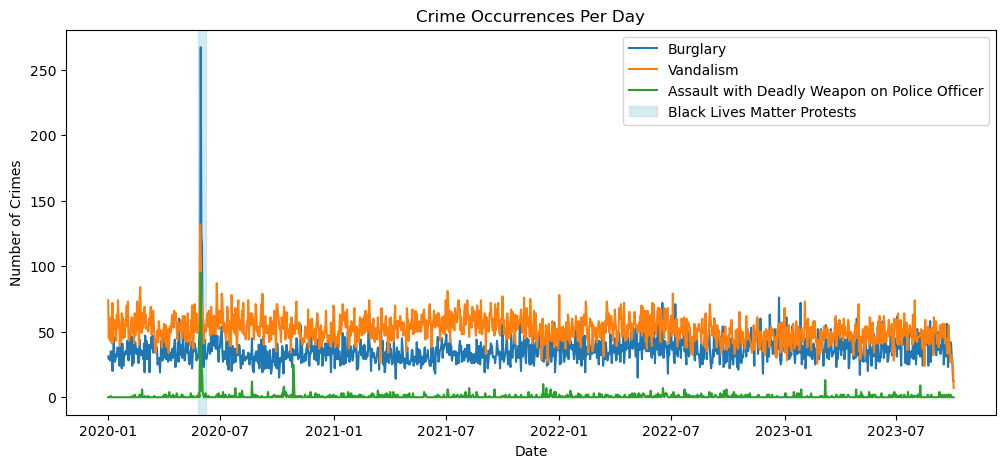

In [284]:
major_events_df = pd.merge(vandalism_date_occ_counts_df, assault_date_occ_counts_df, on="Date", how="outer").merge(burglary_date_occ_counts_df, on="Date", how="outer")
major_events_df = major_events_df.fillna(0)

plt.figure(figsize=(12, 5))
plt.title("Crime Occurrences Per Day")
crimes_by_day = sns.lineplot(data=major_events_df, x="Date", y="Number of Crimes (Burglary)", label="Burglary")
sns.lineplot(data=major_events_df, x="Date", y="Number of Crimes (Vandalism)", label="Vandalism")
sns.lineplot(data=major_events_df, x="Date", y="Number of Crimes (Assault)", label="Assault with Deadly Weapon on Police Officer")
crimes_by_day.set_ylabel("Number of Crimes")

start_date = datetime.datetime.strptime('2020-05-26', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2020-06-07', "%Y-%m-%d")

plt.axvspan(start_date, end_date, alpha=0.5, color='lightblue', label='Black Lives Matter Protests')

plt.legend()
plt.show()

<b>Inference:</b> It can be noted from the above chart that there is a significant increase in burglary crimes, vandalism-related crimes, and crimes related to assault with a deadly weapon on police officers during the period of May 26, 2020, until June 7, 2020. This coincides with the timeframe of Black Lives Matter Protests in the city of Los Angeles. These observations collectively suggest a potential link between the onset of the protests and the notable increase in these specific types of crimes in the city. However, it has been observed that these crimes were highest during the initial days of the protests and have immediately subsided.

### Outliers and Anomalies:

#### Analysing the `Date Difference` attribute to check for outliers and anomalies:

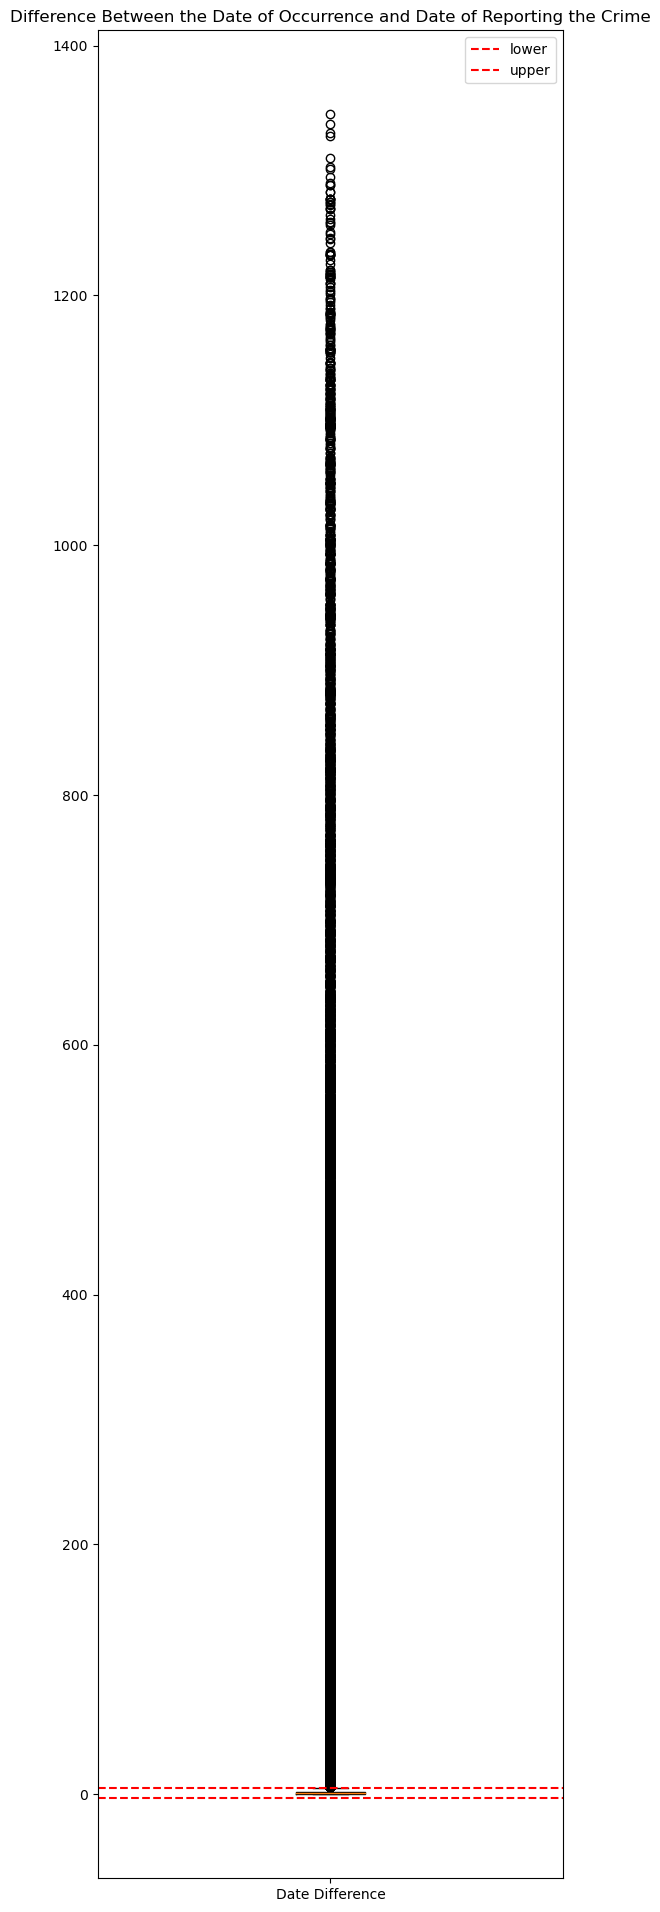

In [285]:
Q1 = crime_data["Date Difference"].quantile(0.25)
Q3 = crime_data["Date Difference"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(6, 24))
plt.boxplot(data=crime_data, x="Date Difference", labels=["Date Difference"])
plt.axhline(lower_bound, color="r", linestyle="--", label="lower")
plt.axhline(upper_bound, color="r", linestyle="--", label="upper")
plt.title("Difference Between the Date of Occurrence and Date of Reporting the Crime")
plt.legend()
plt.show()

<b>Inference:</b> It can be noted from the above box plot chart that there are a significant number of outliers above the upper bound of the turkey fence based on the difference between the date of occurrence and date of reporting the crime in the crime dataset. The reason behind this could be due to crimes being reported significantly later than they occurred. This might be due to delayed discovery of the crime, reluctance from the victim to report the crime and various other factors.

#### Analysing the `Vict Age` attribute to check for outliers and anomalies:

In [286]:
crime_data['Vict Age'].describe()

count    811663.000000
mean         29.828150
std          21.769578
min          -3.000000
25%           8.000000
50%          31.000000
75%          45.000000
max         120.000000
Name: Vict Age, dtype: float64

Clearly there are outliers or error values in the age data as we have `-3` as minimum value. This is an error because the values of the `Vict Age` attribute cannot be negative.

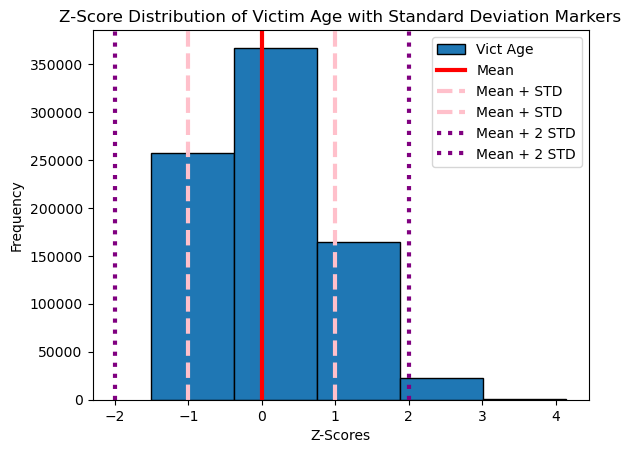

In [287]:
m, s = crime_data['Vict Age'].mean(), crime_data['Vict Age'].std()
zscores = crime_data['Vict Age'] - m 
zscores = zscores / s

num_bins = 5
zscores.plot.hist(bins=num_bins, edgecolor='black')
plt.title('Z-Score Distribution of Victim Age with Standard Deviation Markers')

m, s = zscores.mean(), zscores.std()

plt.axvline(x=m, color='red', linestyle='-', 
            linewidth=3, label='Mean')
plt.axvline(x=m+s, color='pink', linestyle='--',
            linewidth=3, label='Mean + STD')
plt.axvline(x=m-s, color='pink', linestyle='--', 
            linewidth=3, label='Mean + STD')
plt.axvline(x=m+(2*s), color='purple', linestyle='dotted',
            linewidth=3, label='Mean + 2 STD')
plt.axvline(x=m-(2*s), color='purple', linestyle='dotted', 
            linewidth=3, label='Mean + 2 STD')

plt.xlabel('Z-Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

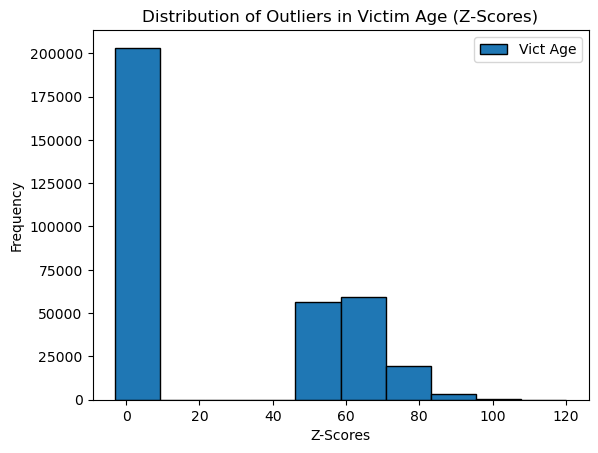

In [288]:
num_stds = 1
m, s = zscores.mean(), zscores.std()
mM2, mP2 = m - (num_stds * s), m + (num_stds * s)

age_filter_right= zscores > mP2
age_filter_left = zscores < mM2

crime_data_outlier_df = pd.concat([crime_data[age_filter_left], crime_data[age_filter_right]])

crime_data_outlier_df[['Vict Age']].plot.hist(edgecolor='black')

plt.xlabel('Z-Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Outliers in Victim Age (Z-Scores)')
plt.show()

In [289]:
print("Frequency of Ages Below 0")
crime_data[crime_data['Vict Age']<0]['Vict Age'].value_counts()

Frequency of Ages Below 0


-1    55
-2    12
-3     1
Name: Vict Age, dtype: int64

In [290]:
crime_data = crime_data[crime_data['Vict Age']>=0]

In [291]:
crime_data.reset_index(drop=True, inplace=True)

<b>Inference:</b> Overall, we can notice that `60%` of the dataset has victims between the age range of `10 to 50`. This age group represents a common demographic for crime victims. The age range between `50 to 100` is not considered outliers as it is not unusual for older individuals to be targeted in various crime types. However, the presence of values in negative range `(-3 to -1)` appears unusual and inconsistent with the typical victim age data. We have noticed that a total of `69` records exhibit this anomaly. It may be advisable to remove these records from the dataset to ensure data integrity and accuracy in further analysis based on demographic factors.

### 9. Demographic Factors:

As we have replaced all the `NaN` and unrecognized values with `X` i.e. `Unknown` during data preprocessing, this action has made `X` as a more dominant category in the `Vict Sex` and `Vict Descent` attributes. Since we cannot infer anything from the `Unknown` category, we are eliminating this category from some of our visualizations.

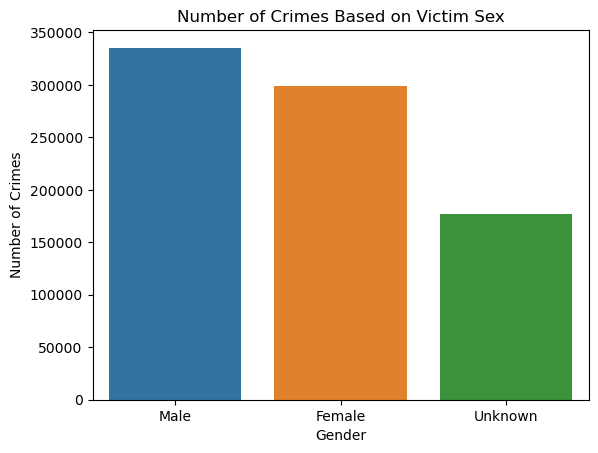

In [292]:
v_gender_df = crime_data['Vict Sex'].value_counts().reset_index(name='crime-counts').rename(columns={'index': 'Gender'})
v_gender_df = v_gender_df[v_gender_df['Gender'].isin(['M', 'F', 'X'])]
plt.title(f'Number of Crimes Based on Victim Sex')
sns.barplot(data=v_gender_df, x='Gender', y='crime-counts')
plt.xlabel('Gender')
plt.xticks(range(0, 3), ['Male', 'Female', 'Unknown'])
plt.ylabel('Number of Crimes')
plt.show()

<b>Inference:</b> We can notice from the above bar graph that the number of crimes experienced by male victims is higher when compared to female victims. Also, we can notice that there is a category with placeholder called `Unknown` representing missing values in the `Vict Sex` attribute. This `Unknown` category can be a result of various factors such as incomplete reporting, privacy of the individuals involved in the incident and human errors during crime reporting.

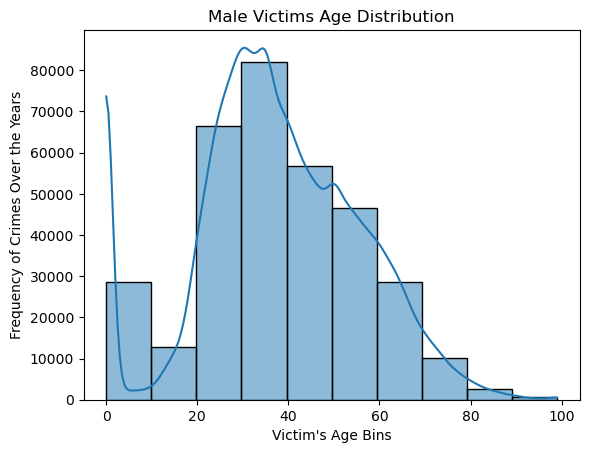

In [293]:
v_age_male = crime_data[crime_data['Vict Sex'] == 'M']['Vict Age']
sns.histplot(v_age_male, bins=10, kde=True)
plt.title("Male Victims Age Distribution")
plt.xlabel("Victim's Age Bins")
plt.ylabel("Frequency of Crimes Over the Years")
plt.show()

<b>Inference:</b> A majority of the Male victims are in the age groups of `(20 - 60)`.

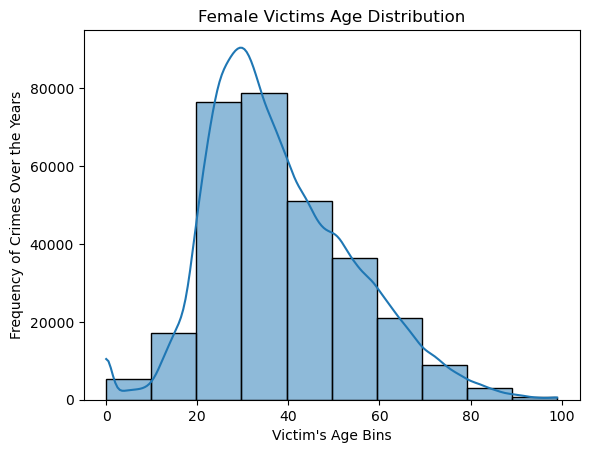

In [294]:
v_age_female = crime_data[crime_data['Vict Sex'] == 'F']['Vict Age']
sns.histplot(v_age_female, bins=10, kde=True)
plt.title("Female Victims Age Distribution")
plt.xlabel("Victim's Age Bins")
plt.ylabel("Frequency of Crimes Over the Years")
plt.show()

<b>Inference:</b>  A majority of the Male victims are in the age groups of `(20 - 50)`.

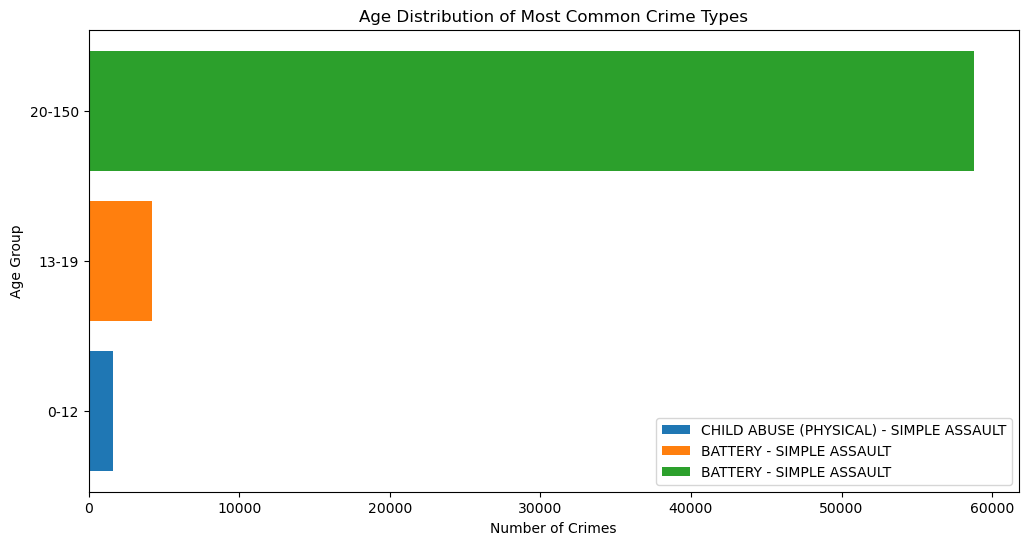

In [295]:
# Defining age groups
age_bins = [0, 12, 19, 150]

# Defining labels for age groups
age_labels = ['0-12', '13-19', '20-150']

crime_data['Age Group'] = pd.cut(crime_data['Vict Age'], bins=age_bins, labels=age_labels)
grouped_age_data = crime_data.groupby(['Age Group', 'Crm Cd Desc']).size().reset_index(name='Vict_Age_Crime_Count')

# Creating a dictionary to store data for each age group
age_group_data = {}


age_groups = grouped_age_data['Age Group'].unique()


plt.figure(figsize=(12, 6))

# Iterating through each age group and create a bar plot
for age_group in age_groups:
    age_group_data[age_group] = grouped_age_data[grouped_age_data['Age Group'] == age_group]
    top_crime = age_group_data[age_group].loc[age_group_data[age_group]['Vict_Age_Crime_Count'].idxmax()]['Crm Cd Desc']
    plt.barh(age_group, age_group_data[age_group]['Vict_Age_Crime_Count'].max(), label=f'{top_crime}')

plt.title('Age Distribution of Most Common Crime Types')
plt.xlabel('Number of Crimes')
plt.ylabel('Age Group')
plt.legend()
plt.show()

<b>Inference:</b> The bar graph suggests that victims in the age group of `0-12` i.e. children, primarily experience `CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT`, while teenagers in the age group of `13-19` and adults in the age group of `20-150` are more likely to be victims of the crime type `BATTERY - SIMPLE ASSAULT`.

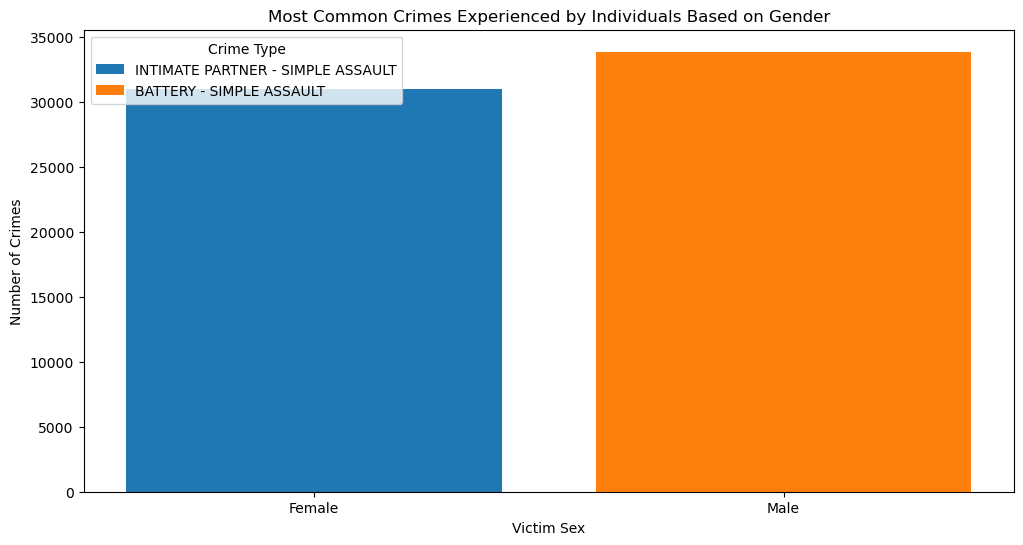

In [296]:
grouped_sex_data = crime_data.groupby(['Vict Sex','Crm Cd Desc' ]).size().reset_index(name='Vict_Sex_Crime_Count')
grouped_sex_data['Vict Sex'] = grouped_sex_data['Vict Sex'].replace({'M': 'Male', 'F': 'Female', 'X': 'Unknown'})
filtered_data = grouped_sex_data[grouped_sex_data['Vict Sex'].isin(['Male', 'Female'])]

sex_groups = filtered_data['Vict Sex'].unique()
plt.figure(figsize=(12,6))

#Iterating through distinct values of Vict Sex and create a bar plot for most reported crime type for each gender
for sex in sex_groups:
    # Sorting the data by crime count in descending order
    top_crime = filtered_data[filtered_data['Vict Sex'] == sex] \
        .sort_values(by='Vict_Sex_Crime_Count', ascending=False) \
        .head(1)
    
    # Extracting the crime description and count for the most common crime
    top_crime_desc = top_crime['Crm Cd Desc'].values[0]
    top_crime_count = top_crime['Vict_Sex_Crime_Count'].values[0]

    plt.bar(sex, top_crime_count, label=f'{top_crime_desc}')

plt.xlabel('Victim Sex')
plt.ylabel('Number of Crimes')
plt.title('Most Common Crimes Experienced by Individuals Based on Gender')
plt.legend(title='Crime Type', loc='upper left')
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that most females are the victims of the crime type - `INTIMATE PARTNER - SIMPLE ASSAULT`, whereas most males are the victims of the crime type `BATTERY - SIMPLE ASSAULT`.

#### Further analysis of female victims for the crime type - 'INTIMATE PARTNER - SIMPLE ASSUALT' by ethnic descent:

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_30076\2528044506.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



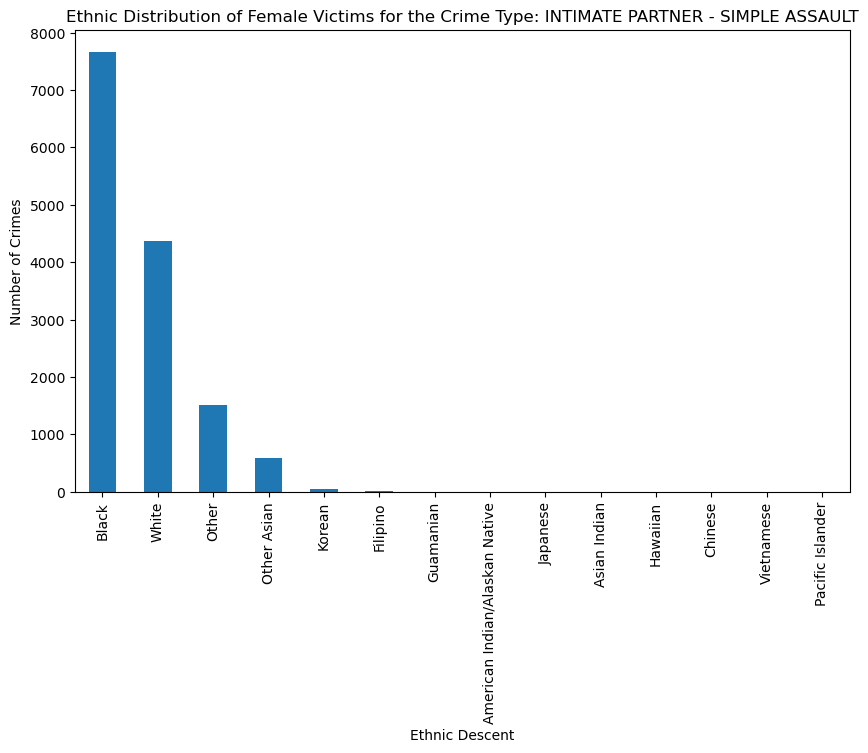

In [297]:
# Filter the DataFrame to include only 'F' (Females) and 'INTIMATE PARTNER - SIMPLE ASSAULT'
filtered_data = crime_data[(crime_data['Vict Sex'] == 'F') & (crime_data['Crm Cd Desc'] == 'INTIMATE PARTNER - SIMPLE ASSAULT')&
                          (crime_data['Vict Descent'] != 'X')]
filtered_data.loc[:, 'Vict Descent'] = filtered_data['Vict Descent'].replace(race_map)

# Group by 'Vict Descent' and calculating the count of each ethnicity
ethnicity_counts = filtered_data['Vict Descent'].value_counts()

# Creating a bar plot to visualize the ethnicity of females victims reporting the crime type: INTIMATE PARTNER - SIMPLE ASSAULT
plt.figure(figsize=(10, 6))
ethnicity_counts.plot(kind='bar')
plt.xlabel('Ethnic Descent')
plt.xticks(rotation=90)
plt.ylabel('Number of Crimes')
plt.title('Ethnic Distribution of Female Victims for the Crime Type: INTIMATE PARTNER - SIMPLE ASSAULT')
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that female victims of the `Black` community have the highest reported cases of the crime type `INTIMATE PARTNER - SIMPLE ASSAULT` indicating a significant prevelance of this crime in the `Black` community.

#### Further analysis of male victims for the crime type - 'BATTERY - SIMPLE ASSAULT' by ethnic descent:

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_30076\1001485333.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



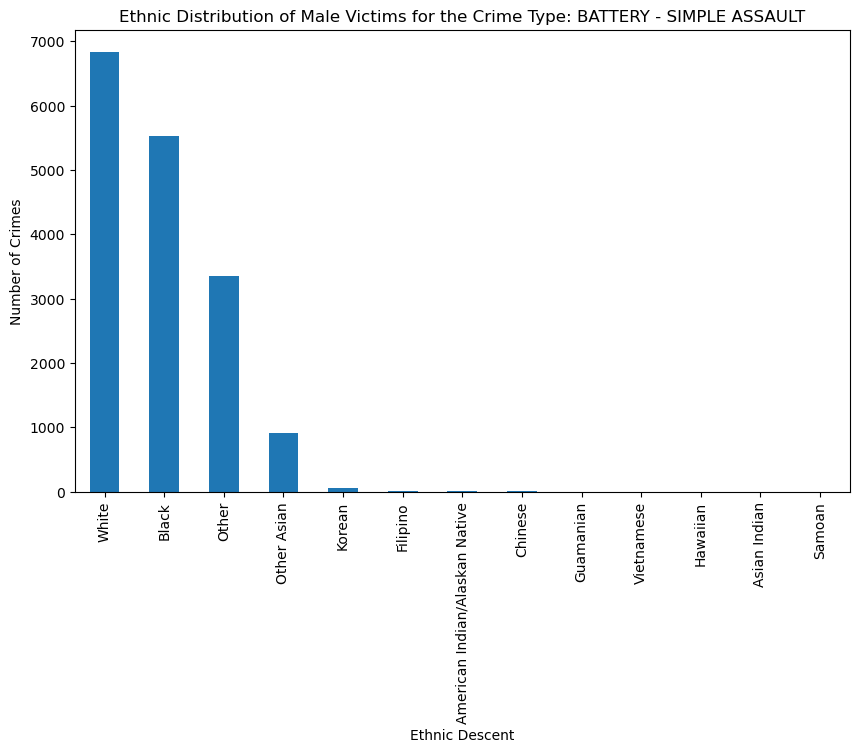

In [298]:
# Filtering the crime dataset to include only 'M' (Males) and 'BATTERY - SIMPLE ASSAULT'
filtered_data = crime_data[(crime_data['Vict Sex'] == 'M') & (crime_data['Crm Cd Desc'] == 'BATTERY - SIMPLE ASSAULT')&
                          (crime_data['Vict Descent'] != 'X')]
filtered_data['Vict Descent'] = filtered_data['Vict Descent'].replace(race_map)

# Grouping by 'Vict Descent' and calculating the count of each ethnicity
ethnicity_counts = filtered_data['Vict Descent'].value_counts()

# Creating a bar plot to visualize the ethnicity of male victims reporting the crime type: BATTERY - SIMPLE ASSAULT
plt.figure(figsize=(10, 6))
ethnicity_counts.plot(kind='bar')
plt.xlabel('Ethnic Descent')
plt.ylabel('Number of Crimes')
plt.title('Ethnic Distribution of Male Victims for the Crime Type: BATTERY - SIMPLE ASSAULT')
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that male victims of the `White` community have the highest reported cases of the crime type `BATTERY - SIMPLE ASSAULT` indicating a significant prevelance of this crime on the `White` community.

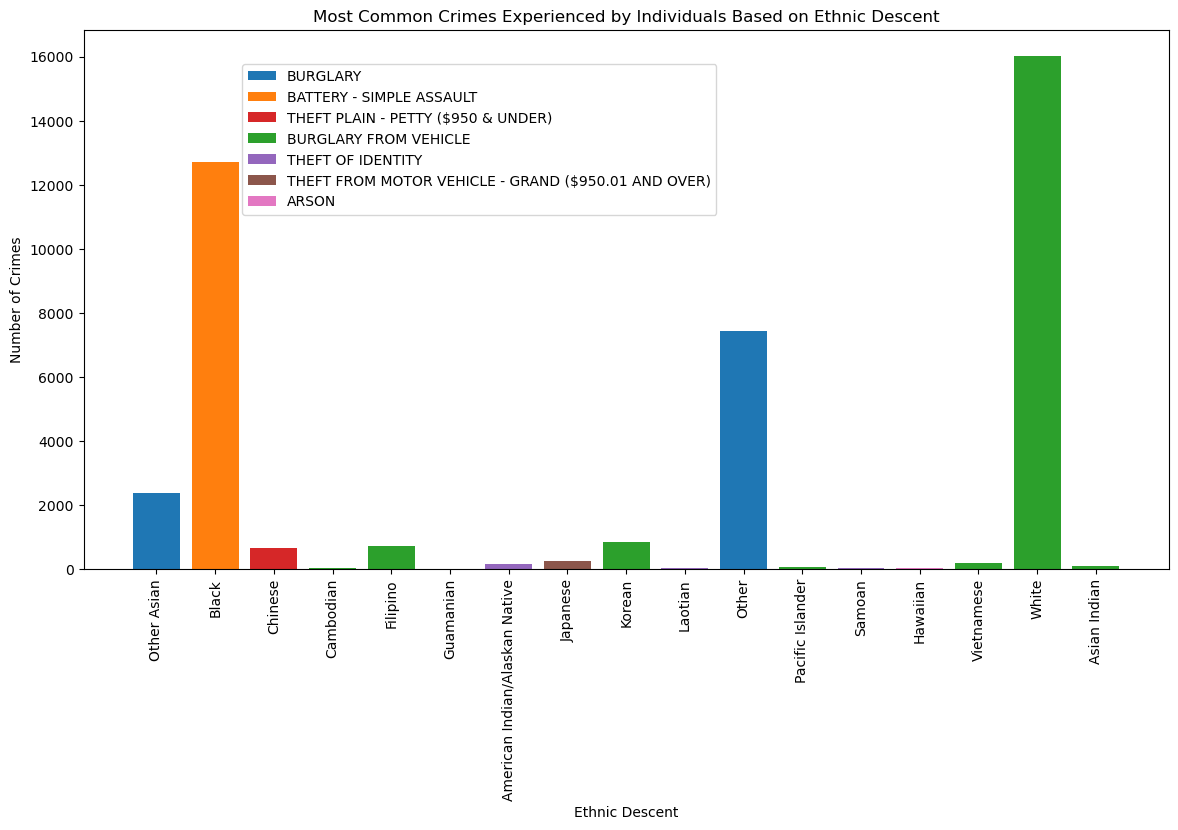

In [299]:
# Grouping the data by 'Vict Descent' and 'Crm Cd Desc' and calculate the count of each combination
grouped_descent_data = crime_data.groupby(['Vict Descent', 'Crm Cd Desc']).size().reset_index(name='Vict_Descent_Crime_Count')

# Replacing ethnicity codes with full forms
grouped_descent_data['Vict Descent'] = grouped_descent_data['Vict Descent'].replace(race_map)

# Filtering the data to exclude 'Unknown' ethnicity
grouped_descent_data = grouped_descent_data[grouped_descent_data['Vict Descent'] != 'Unknown']

descent_groups = grouped_descent_data['Vict Descent'].unique()

plt.figure(figsize=(14, 7))

top_crime_dict = {}
colors_index = 0
colors=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd', '#8c564b', '#e377c2']

# Iterating through distinct values of Vict Descent and create a bar plot for the most reported crime type for each ethnic group
for descent in descent_groups:
    top_crime = grouped_descent_data[grouped_descent_data['Vict Descent'] == descent] \
        .sort_values(by='Vict_Descent_Crime_Count', ascending=False) \
        .head(1)

    # Extracting the crime description and count for the most common crime
    top_crime_desc = top_crime['Crm Cd Desc'].values[0]
    top_crime_count = top_crime['Vict_Descent_Crime_Count'].values[0]
    
    if top_crime_desc not in top_crime_dict:
        top_crime_dict[top_crime_desc] = colors[colors_index]
        colors_index += 1
        plt.bar(descent, top_crime_count, label=f'{top_crime_desc}',color=top_crime_dict[top_crime_desc])
    else:
        plt.bar(descent, top_crime_count, color=top_crime_dict[top_crime_desc])

plt.xlabel('Ethnic Descent')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.title("Most Common Crimes Experienced by Individuals Based on Ethnic Descent")
plt.legend(bbox_to_anchor=(0.14,0.95))
plt.show()

<b>Inference:</b> It can be noted from the above bar graph that individuals of most ethnic groups such as - `Cambodian`, `Filipino`, `Guamanian`, `Korean`, `Pacific Islander`, `Vietnamese`, `White`, `Asian Indian` were victims of the crime type - `BURGLARY FROM VEHICLE`, with individuals from the `White` ethnic community experiencing it the highest when compared to the remaining ethnic groups. This was followed by the crime type - `BATTERY - SIMPLE ASSAULT` which is faced by individuals of `Black` descent.

In [300]:
x = crime_data[~crime_data['Vict Descent Descp'].isin(['Unknown'])]['Vict Descent Descp'].value_counts(normalize=True)
x = x.reset_index().rename(columns={'index': 'race', 'Vict Descent Descp': 'targetted count'})

fig = px.line_polar(x, 
                    r='targetted count', 
                    theta='race', 
                    line_close=True,
                    title="Percentage of Victim Descent Targetted Over the Years"
                   )
fig.update_traces(
    fill='toself', 
    name='Races targetted'
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    paper_bgcolor="LightSteelBlue",
)
fig.update_polars(radialaxis_tickformat='%')
fig.show()

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<b>Inference:</b> When looking at the overall crimes against a community, from the years 2020 to 2023, it is seen that `Latin/Mexican/Hispanic` descent followed by `White` & `Black` communities.

### 10. Predicting Future Trends:
Here, we have choosen `Prophet` model to train a `univariate time-series forcasting model` to `predict the number of crimes per day`. <br><br><b>Data Preparation:</b><br> The following steps are necessary to prepare the input for model training:
- Compute the number of crimes per day of occurance
- Rename columns as `DS` for datetime column and `y` for number of crimes column. This is essential because Prophet expects the model input to be in this specific format.

In [301]:
univariate_df = crime_data[['DATE OCC']].rename(columns={'DATE OCC': 'date'})
univariate_df = univariate_df.groupby(['date']).size().reset_index(name='crime-counts')
univariate_df['ds'] = pd.to_datetime(univariate_df['date'])
univariate_df = univariate_df.set_index('ds')
univariate_df = univariate_df.resample('D').sum()
univariate_df = univariate_df.reset_index().rename(columns={'crime-counts': 'y', })
univariate_df.head()

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_30076\1029976972.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,ds,y
0,2020-01-01,1100
1,2020-01-02,526
2,2020-01-03,595
3,2020-01-04,540
4,2020-01-05,505


<b>Data Split:</b><br>Split the data into train and test split. This is essential to evaluate the model's performace later.<br><br>
Crime incidents from `Jan 2020 to June 2023` are considered for `training set` and incidents from `June 2023 to Oct 2023` are considered for `testing set`.

In [302]:
train_uni = univariate_df[univariate_df['ds'] < '2023-06-01']
test_uni = univariate_df[univariate_df['ds'] > '2023-06-01']
print(f'Train size: {len(train_uni)}, Test size: {len(test_uni)}')

Train size: 1247, Test size: 123


<b>Training:</b><br>Initialising Prophet model with an uncertanity interval of `95%`

In [303]:
model = Prophet(interval_width=0.95)
model.fit(univariate_df)

16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:51 - cmdstanpy - INFO - Chain [1] done processing


<b>Test set evaluation:</b> <br>Let's see how the model performs against the test set samples

In [304]:
forecast = model.predict(test_uni[['ds']])

In [305]:
y_preds = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [306]:
test_comp_df = pd.merge(y_preds, test_uni, on='ds').set_index('ds')

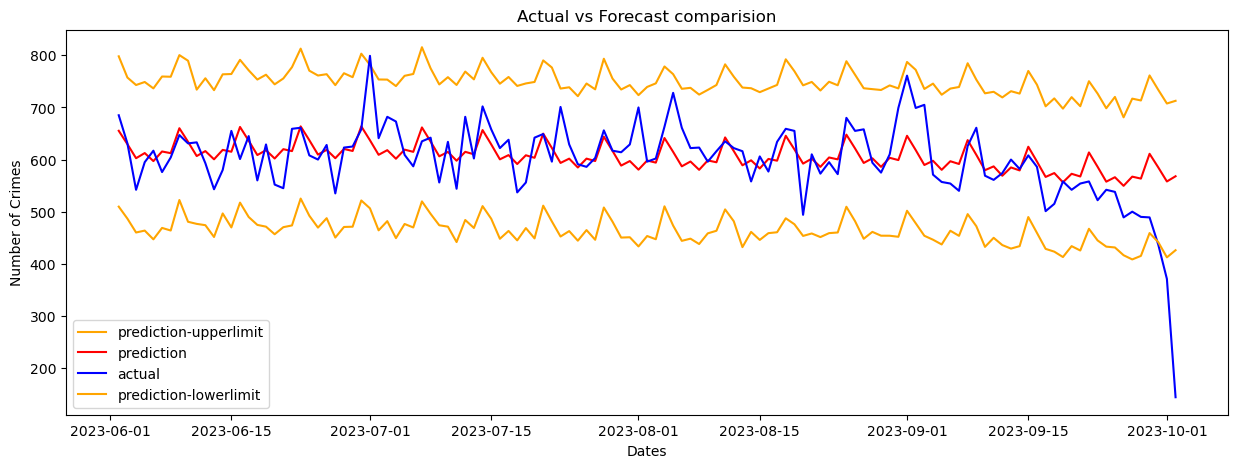

In [307]:
plt.figure(figsize=(15, 5))

sns.lineplot(test_comp_df['yhat_upper'], color='orange', label='prediction-upperlimit')
sns.lineplot(test_comp_df['yhat'], color='red', label='prediction')
sns.lineplot(test_comp_df['y'], color='blue', label='actual')
sns.lineplot(test_comp_df['yhat_lower'], color='orange', label='prediction-lowerlimit')
plt.title('Actual vs Forecast comparision')
plt.xlabel('Dates')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [308]:
mse = mean_squared_error(test_comp_df['y'], test_comp_df['yhat'])
r2 = r2_score(test_comp_df['y'], test_comp_df['yhat'])
print(f'MSE: {mse}\nR2: {r2}')

MSE: 4120.166516308896
R2: 0.2555931281593492


<b>Weekly Prediction</b><br>Now instead of the whole testset, we now check how the model performs for the dates only 1 week after the end of training set. This is done with the understanding that as the prediction window moves away from the latest training sample, more importantly in time-series data, the uncertainity in predictions increases.

In [309]:
forecast_dates = pd.DataFrame({'ds': ['2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06', '2023-06-07']})

In [310]:
weekly_forecast = model.predict(forecast_dates[['ds']])

In [311]:
weekly_y_preds = weekly_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [312]:
weekly_test_comp_df = pd.merge(weekly_y_preds, test_uni, on='ds').set_index('ds')

In [313]:
weekly_test_comp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2023-06-02,655.192521,513.747145,789.473256,685
2023-06-03,629.504429,488.506820,779.743428,631
2023-06-04,602.584830,448.827414,738.385152,542
2023-06-05,612.458348,466.449679,745.208026,595
2023-06-06,597.057104,469.124807,747.658028,617
2023-06-07,615.485592,474.980452,766.067492,576


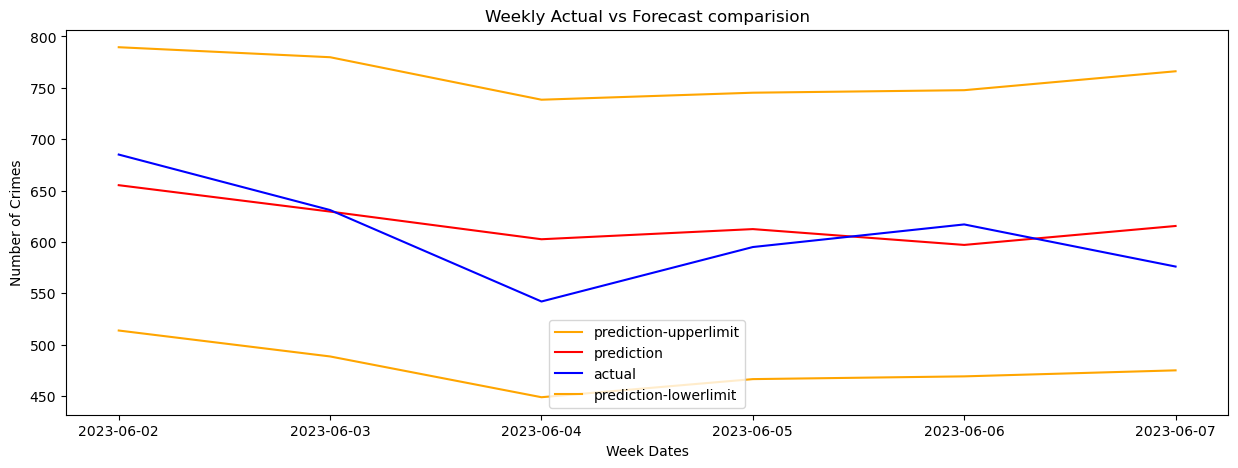

In [314]:
plt.figure(figsize=(15, 5))

sns.lineplot(weekly_test_comp_df['yhat_upper'], color='orange', label='prediction-upperlimit')
sns.lineplot(weekly_test_comp_df['yhat'], color='red', label='prediction')
sns.lineplot(weekly_test_comp_df['y'], color='blue', label='actual')
sns.lineplot(weekly_test_comp_df['yhat_lower'], color='orange', label='prediction-lowerlimit')
plt.title('Weekly Actual vs Forecast comparision')
plt.xlabel('Week Dates')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [315]:
mse = mean_squared_error(weekly_test_comp_df['y'], weekly_test_comp_df['yhat'])
r2 = r2_score(weekly_test_comp_df['y'], weekly_test_comp_df['yhat'])
print(f'MSE: {mse}\nR2: {r2}')

MSE: 1137.1448600411522
R2: 0.43553561632726434


<b>Inference:</b> We can see from above comparison graphs that Prophet's predictions are able to closely compare with the actual crime counts for the LA city. Furthermore, the model also provides a upper & lower limit of the prediction to help us with a range of crimes occurances per day. On the testing set, for a forecasting window of `June 2023` to `Oct 2023`, the model recieves an R2 score of `0.25` indicating that it was able to capture `25%` of the variance present in the data. For weekly forecasting period from `02 June 23` to `07 June 23`, the model receives a R2 score of `0.43` thereby showing good performance in predicting next 7 days forecast right after the end of training data. Therefore the model performs good in learning the patterns in the number of crime occurances per day and helps in predicting the future crimes.